# Project: Electric Vehicle Charging Scheduling Problem (EVCS)
## Final deliverable
## Prescriptive Analytics: Heuristics for Decision Making
### Wilmar Calderón - 201630701

The Electric Vehicle Charging Scheduling (EVCS) problems aims to determine the optimal sequence of charging $n$ vehicles in $m$ chargers. The EVCS can be formulated with multiple objectives as reducing cost or maximizing the charge, which are the most common objectives for the problem. This implementation describes a constructive Heuristic formulation to obtain an initial and feasible solution for the EVCS. The proposed implementation considers two approaches, first, the Earliest Departure First (EDF) and the First Come First Served (FCFS) approach. the former, prioritizes the vehicles that have the nearest departure time to schedule its charge first, the latter considers that the first vehcile that arrives should be attended. Implementation of the Heuristic is described below.

In [52]:
import json
import pandas as pd
from typing import Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import time
import random
import copy
import optuna
from functools import partial

In [53]:
# --- Constants and Configuration ---
STEP_DURATION = 0.25  # Time spacing: Model parameter (fraction of an hour)
seed=10
random.seed(seed)
np.random.seed(seed)

# --- Helper Functions ---

#Convert the time to the index
def time_to_index(t, delta_t=STEP_DURATION):
    """Converts time to a slot index."""
    return int(round(t / delta_t))

#Convert the indices to time (fraction of hours)
def index_to_time(idx, delta_t=STEP_DURATION):
    """Converts a slot index back to time."""
    return round(idx * delta_t, 2) # Keep precision consistent

In [54]:
#Loads data from JSON and preprocesses it for ILS. Returns a dictionary of processed data."
def load_and_preprocess_data(file_path):
    #loads the JSON with the instance details
    with open(file_path, 'r') as file:
        data = json.load(file)

    #Dictionary to store the information
    processed_data = {}

    # Energy Prices
    energy_prices_df = pd.DataFrame(data['energy_prices'], columns=['time', 'price'])
    processed_data['energy_prices_df'] = energy_prices_df

    # EV Arrivals
    arrivals_df = pd.DataFrame(data['arrivals'], columns=['id', 'arrival_time', 'departure_time', 'required_energy', 'brand','min_charge_rate', 'max_charge_rate'])
    
    # Ensure consistent indexing for EVs (0 to N-1)
    arrivals_df = arrivals_df.sort_values(by='id').reset_index(drop=True)
    arrivals_df['ev_idx'] = arrivals_df.index 

    #Convert the arrival and departure time to the corresponding indexes in the arrays
    arrivals_df['arrival_slot_idx'] = arrivals_df['arrival_time'].apply(lambda t: time_to_index(t, STEP_DURATION))
    arrivals_df['departure_slot_idx'] = arrivals_df['departure_time'].apply(lambda t: time_to_index(t, STEP_DURATION))
    
    #Min/max energy per EV arrival based on rates of the EV
    arrivals_df['min_energy_per_slot'] = arrivals_df['min_charge_rate'] * STEP_DURATION
    arrivals_df['max_energy_per_slot'] = arrivals_df['max_charge_rate'] * STEP_DURATION

    #Stores the information of the EV in the Dictionary that will be returned
    processed_data['arrivals_df'] = arrivals_df
    processed_data['num_evs'] = len(arrivals_df)

    # Chargers
    parking_config = data.get('parking_config', {})
    chargers_df = pd.DataFrame(parking_config['chargers'], columns=["charger_id", "power", "type", "operation_cost_per_hour", "compatible_vehicles"])

    # Ensure consistent indexing for chargers (0 to M-1)
    chargers_df = chargers_df.sort_values(by='charger_id').reset_index(drop=True)
    chargers_df['charger_idx'] = chargers_df.index
    #Define the maximum charging rate of each charger
    chargers_df['energy_capacity_per_slot'] = chargers_df['power'] * STEP_DURATION


    #Stores the information of the Station and the chargers in the Dictionary that will be returned
    processed_data['chargers_df'] = chargers_df
    processed_data['num_chargers'] = len(chargers_df)

    processed_data['transformer_limit_kw'] = parking_config['transformer_limit']
    processed_data['transformer_energy_limit_per_slot'] = parking_config['transformer_limit'] * STEP_DURATION
    
    

    # Mapping of the time indices and the price database to store the prices of energy based on the details given in the instance. 
    # Step of the analysis is not the same as the time definition of the price database, then the indices are adjusted
    
    # Max time slot
    # Ensure max_departure_time is valid before processing
    if arrivals_df['departure_time'].empty:
        max_departure_time = 0 # Default if no departures
    else:
        max_departure_time = arrivals_df['departure_time'].max()

    #Get the number of indices that the timetable must have
    processed_data['num_time_slots'] = time_to_index(max_departure_time, STEP_DURATION) + 1 # Slots are 0-indexed
    #Create the list of time indices
    time_slots_actual = [index_to_time(i, STEP_DURATION) for i in range(processed_data['num_time_slots'])]
    all_slots_df = pd.DataFrame({'time': time_slots_actual})
    
    if not energy_prices_df.empty:
        merged_prices_df = pd.merge_asof(all_slots_df.sort_values('time'), 
                                         energy_prices_df.sort_values('time'), 
                                         on='time', 
                                         direction='backward')
        # Forward fill any remaining NaNs (e.g., if first slot is before first price point)
        # Then backfill any at the very beginning if still NaN
        merged_prices_df['price'] = merged_prices_df['price'].ffill().bfill().fillna(0) 
        processed_data['energy_prices_at_t_idx'] = merged_prices_df['price'].values
    else: # Handle case with no energy prices
        processed_data['energy_prices_at_t_idx'] = np.zeros(processed_data['num_time_slots'])


    # Charger compatibility matrix A[ev_idx, charger_idx]
    # 1 if charger and EV are compatible, 0 otherwise
    A = np.zeros((processed_data['num_evs'], processed_data['num_chargers']), dtype=int)
    for ev_r_idx, ev_row in arrivals_df.iterrows():
        # Extract base brand name (e.g., "Tesla Model S" from "Tesla Model S 100kWh")
        parts = ev_row["brand"].split(' ')
        if parts[-1].lower().endswith('kwh'): # Check if last part indicates capacity
            ev_brand_base = " ".join(parts[:-1])
        else:
            ev_brand_base = ev_row["brand"]
        #Iterate over the chargers            
        for ch_r_idx, ch_row in chargers_df.iterrows():
            if ev_brand_base in ch_row["compatible_vehicles"]:
                 A[ev_row['ev_idx'], ch_row['charger_idx']] = 1
    processed_data['compatibility_matrix'] = A
    
    # Penalty for unserved energy
    if not energy_prices_df['price'].empty and energy_prices_df['price'].max() > 0 :
        processed_data['penalty_unserved_energy'] = energy_prices_df['price'].max() * 10
    else:
        processed_data['penalty_unserved_energy'] = 1000 # Default if no prices or all prices are zero

    return processed_data

In [55]:
# --- Objective Function ---
#Calculates the objective function. Modeled as a single Objective.
def calculate_objective(solution_P_ict, processed_data):
    #Extract information from the instance
    arrivals_df = processed_data['arrivals_df']
    energy_prices_at_t_idx = processed_data['energy_prices_at_t_idx']
    lambda_p = processed_data['penalty_unserved_energy']
    #Gets the shape of the solution to make the iteration of the charging data
    num_evs, num_chargers, num_time_slots = solution_P_ict.shape

    total_charging_cost = 0
    total_penalty_cost = 0

    #Calculates the energy used by each EV at each period
    energy_per_slot = np.sum(solution_P_ict, axis=(0, 1)) 
    #Calculates the total charging cost
    total_charging_cost = np.sum(energy_per_slot * energy_prices_at_t_idx)

    #itretaes over all the arrivals        
    for ev_idx in range(num_evs):
        ev_info = arrivals_df.iloc[ev_idx]
        required_energy = ev_info['required_energy']
        supplied_energy = np.sum(solution_P_ict[ev_idx, :, :]) 
        #Calculates the energy that wasn't satisfied to be supplied        
        unserved_energy = max(0, required_energy - supplied_energy)
        #calculates the penalty for unattended energy
        total_penalty_cost += lambda_p * unserved_energy
        
    return total_charging_cost + total_penalty_cost

In [56]:
# --- Feasibility Check ---
#Checks if the solution P_ict (Power of EV: i, at charger: c at time: t) and the association between charger and EV (ev_to_charger_map) is feasible under the restrictions modeled.
def is_solution_feasible(P_ict, ev_to_charger_map, processed_data, verbose=False):
    #Extracts information from the instance
    arrivals_df = processed_data['arrivals_df']
    chargers_df = processed_data['chargers_df']
    matrix_a = processed_data['compatibility_matrix']
    t_limit = processed_data['transformer_energy_limit_per_slot']
    num_evs, num_chargers, num_time_slots = P_ict.shape
    epsilon = 1e-6 # Tolerance for float comparisons

    #Loop over all time periods
    for t_idx in range(num_time_slots):

        ## Restriction 2: Transformer Power Limit
        current_load = np.sum(P_ict[:, :, t_idx])
        if current_load > t_limit + epsilon:
            if verbose: print(f"Feasibility Error: Transformer limit exceeded at t_idx {t_idx}. Load: {current_load:.2f}, Limit: {t_limit:.2f}")
            return False

        ## Restriction 3: Charger limit & Restriction 7: Maximum one EV per Charger
        # Restriction 1: Respect chargers limit (limited as the iteration of chargers is limited to the Chargers details)
        for c_idx in range(num_chargers):
            # Restriction 3: Charger limit
            charger_info = chargers_df.iloc[c_idx]
            current_charger_load = np.sum(P_ict[:, c_idx, t_idx])
            if current_charger_load > charger_info['energy_capacity_per_slot'] + epsilon:
                if verbose: print(f"Feasibility Error: Charger {c_idx} capacity exceeded at t_idx {t_idx}. Load: {current_charger_load:.2f}, Capacity: {charger_info['energy_capacity_per_slot']:.2f}")
                return False
            # Restriction 7: Maximum one EV per Charger
            evs_on_charger = [ev_idx for ev_idx in range(num_evs) if P_ict[ev_idx, c_idx, t_idx] > epsilon]
            if len(evs_on_charger) > 1:
                if verbose: print(f"Feasibility Error: Multiple EVs ({evs_on_charger}) on charger {c_idx} at t_idx {t_idx}")
                return False

    #Loop over all arrivals (EV)
    for ev_idx in range(num_evs):
        ev_info = arrivals_df.iloc[ev_idx]
        active_chargers_to_ev = [c_idx for c_idx in range(num_chargers) if np.sum(P_ict[ev_idx, c_idx, :]) > epsilon]

        #Restriction 6
        if len(active_chargers_to_ev) > 1:
            if verbose: print(f"Feasibility Error: EV {ev_idx} receives energy from multiple chargers: {active_chargers_to_ev}")
            return False
        
        # Identifies the charger that is supplying energy to the EV
        current_active_charger = -1
        if len(active_chargers_to_ev) == 1:
            current_active_charger = active_chargers_to_ev[0]

        if current_active_charger != -1: 

            #Restriction 8: Cars should be charged in compatible chargers
            if matrix_a[ev_idx, current_active_charger] == 0:
                if verbose: print(f"Feasibility Error: EV {ev_idx} incompatible with charger {current_active_charger} it's receiving energy from.")
                return False

            total_energy_for_ev_calc = 0
            for t_idx in range(num_time_slots):
                energy_this_slot = P_ict[ev_idx, current_active_charger, t_idx]
                total_energy_for_ev_calc += energy_this_slot

                if energy_this_slot > epsilon: 
                    #Restriction 4 & 5: Charging only between arrival and departure time
                    if not (ev_info['arrival_slot_idx'] <= t_idx < ev_info['departure_slot_idx']):
                        if verbose: print(f"Feasibility Error: EV {ev_idx} (slots {ev_info['arrival_slot_idx']}-{ev_info['departure_slot_idx']-1}) charging outside window at t_idx {t_idx}")
                        return False

                    #Restriction 10: Charging exceeds car charging rate               
                    if energy_this_slot > ev_info['max_energy_per_slot'] + epsilon:
                        if verbose: print(f"Feasibility Error: EV {ev_idx} exceeded max_energy_per_slot ({ev_info['max_energy_per_slot']:.2f}) with {energy_this_slot:.2f} at t_idx {t_idx}")
                        return False
                    
                    # Min energy per slot check: if charging, must be >= min_energy_per_slot,
                    # UNLESS it's the last bit of energy needed and that bit is < min_energy_per_slot.
                    remaining_needed_for_ev_before_this_slot = ev_info['required_energy'] - (total_energy_for_ev_calc - energy_this_slot)

                    #Restriction 9: Charging rate is lower than admissible from the EV               
                    if energy_this_slot < ev_info['min_energy_per_slot'] - epsilon and \
                       energy_this_slot < remaining_needed_for_ev_before_this_slot - epsilon:
                         if verbose: print(f"Feasibility Error: EV {ev_idx} below min_energy_per_slot ({ev_info['min_energy_per_slot']:.2f}) with {energy_this_slot:.2f} at t_idx {t_idx} (rem needed before this: {remaining_needed_for_ev_before_this_slot:.2f})")
                         return False 
    return True

In [57]:
# --- Initial Solution Generation (Price-Aware Earliest Departure First) ---
def generate_initial_solution_pa_edf(processed_data):
    #extracts the information from the instance
    arrivals_df = processed_data['arrivals_df'].copy() 
    chargers_df = processed_data['chargers_df'].copy()
    energy_prices_at_t_idx = processed_data['energy_prices_at_t_idx']
    matrix_a = processed_data['compatibility_matrix']
    t_limit = processed_data['transformer_energy_limit_per_slot']
    
    num_evs = processed_data['num_evs']
    num_chargers = processed_data['num_chargers']
    num_time_slots = processed_data['num_time_slots']
    epsilon = 1e-6

    #Initializes the matrix where Energy assignation will be stored (variable P(n,c,t))
    P_ict = np.zeros((num_evs, num_chargers, num_time_slots))
    #Initilizes the array where the EV -> charger details will be stored (Variable z(n,c))
    ev_to_charger_map = np.full(num_evs, -1, dtype=int)
    
    #sorts the EV based on the departure time (EDF part)
    sorted_evs_df = arrivals_df.sort_values(by='departure_slot_idx')
    #sorts the chargers in power order, first, the most powerfull chargers will be assigned, then the others)
    sorted_charger_indices = chargers_df.sort_values(by='power', ascending=False)['charger_idx'].tolist()

    #Iterates over the EV details
    for _, ev_row in sorted_evs_df.iterrows():
        #extracts EV details
        ev_idx = ev_row['ev_idx']
        required_energy = ev_row['required_energy']
        min_energy_per_slot_ev = ev_row['min_energy_per_slot']
        max_energy_per_slot_ev = ev_row['max_energy_per_slot']
        arrival_slot = ev_row['arrival_slot_idx']
        departure_slot = ev_row['departure_slot_idx'] 

        #Iterates over the chargers to start assignation
        for charger_idx in sorted_charger_indices:
            #If the EV selected has already one assignation, break as assignation is already made
            if ev_to_charger_map[ev_idx] != -1: break
            # If the charger is not comaptible with the EV: check other chargers
            if matrix_a[ev_idx, charger_idx] == 0:
                continue 

            #Extract charger information
            charger_info = chargers_df.iloc[charger_idx]
            charger_capacity_per_slot = charger_info['energy_capacity_per_slot']
            
            # Check if this charger can accommodate this EV
            charger_available = True
            for t_check in range(arrival_slot, departure_slot):
                if np.sum(P_ict[:, charger_idx, t_check]) > epsilon: # If any *other* EV is on this charger
                    charger_available = False
                    break
            #If the charger is used by another EV at the time (between arrival and departure) search for other charger
            if not charger_available:
                continue

            # Try to schedule this EV on this charger
            P_ict_val = 0
            energy_for_ev = np.zeros(num_time_slots)

            #Create the energy price list (for the periods between arrival and departure time)
            price_slot_pairs = []
            for t_schedule in range(arrival_slot, departure_slot):
                 price_slot_pairs.append((energy_prices_at_t_idx[t_schedule], t_schedule))

            #Sort the assignation time based on price (Price Awaring)            
            sorted_price_slots_for_ev = sorted(price_slot_pairs, key=lambda x: x[0])

            #Time index to review theassign the energy. First, assign the slots with lowest price
            for price, t_idx in sorted_price_slots_for_ev:
                #If total energy supplied (P_ict_val) is more than the assigned, break
                if P_ict_val >= required_energy - epsilon:
                    break 

                # Max energy we can assign in this slot
                energy_needed = required_energy - P_ict_val
                
                #Restrictions checking
                can_assign = energy_needed
                can_assign = min(can_assign, max_energy_per_slot_ev) #less than the EV max charging rate
                can_assign = max(can_assign,min_energy_per_slot_ev) #more than the EV min charging rate
                can_assign = min(can_assign, charger_capacity_per_slot) # Limit of the charger
                can_assign = min(can_assign, t_limit - np.sum(P_ict[:, :, t_idx])) # Limit of the available energy in the transformer
                can_assign = max(0, can_assign) # Ensure non-negative

                #Energy Assignation. Checking if the minimum charging rate is respected. If not, only assign 0 in this period
                actual_assigned_this_slot = 0
                if can_assign >= min_energy_per_slot_ev - epsilon:
                    actual_assigned_this_slot = can_assign
                elif can_assign > epsilon and can_assign >= energy_needed - epsilon: # If less than min_rate, but it's the remainder, assign the remaineder as it should not take all the step
                    actual_assigned_this_slot = can_assign
                
                #IF energy assignation is proposed, update the energy assigned for each time slot and the total energy supplied (P_ict_val)
                if actual_assigned_this_slot > epsilon:
                    energy_for_ev[t_idx] = actual_assigned_this_slot
                    P_ict_val += actual_assigned_this_slot
            
            # If any energy was scheduled for this EV on this charger
            if P_ict_val > epsilon: 
                # Assign the charging schedule to global P_ict and make the assignation EV -> charger
                P_ict[ev_idx, charger_idx, :] = energy_for_ev[:]
                ev_to_charger_map[ev_idx] = charger_idx
                break # As EV is assigned, move to next EV
    
    #calculate objective and return solution (P_ict, ev_to_charger_map, objective)
    objective_val = calculate_objective(P_ict, processed_data)
    return {'P_ict': P_ict, 'ev_to_charger_map': ev_to_charger_map, 'objective': objective_val}


In [58]:
#Generates an initial solution using a Slack-Aware First Come First Served heuristic.
# 1 EVs sorted by FCFS (arrival), then by lower slack.
# 2 Low slack EVs charge earliest possible slots.
# 3 High slack EVs charge cheapest possible slots.
def generate_initial_solution_sa_fcfs(processed_data, low_slack_threshold_hours=1.0):
    #Retrieves the information from the instance file
    arrivals_df = processed_data['arrivals_df'].copy() 
    chargers_df = processed_data['chargers_df'].copy()
    energy_prices_at_t_idx = processed_data['energy_prices_at_t_idx']
    matrix_a = processed_data['compatibility_matrix']
    t_limit = processed_data['transformer_energy_limit_per_slot']
    
    num_evs = processed_data['num_evs']
    num_chargers = processed_data['num_chargers']
    num_time_slots = processed_data['num_time_slots']
    epsilon = 1e-6

    #Initilizes the dataframes to store the solutions
    P_ict = np.zeros((num_evs, num_chargers, num_time_slots))
    ev_to_charger_map = np.full(num_evs, -1, dtype=int)

    #Calculate Slack for each EV
    if chargers_df.empty:
        min_system_charger_power = 7.0*STEP_DURATION # Default if no chargers (sets the slack in the same terms as the dataframe is)
    else:
        min_system_charger_power = chargers_df['power'].min()
        if min_system_charger_power <= epsilon: # Avoid division by zero if slowest charger has 0 power
             min_system_charger_power = 1.0*STEP_DURATION

    #stores the slack time for charging (differnece between stay duration and the time needed to charge)
    slacks = []
    for idx, ev_row in arrivals_df.iterrows():
        effective_rate = min(ev_row['max_charge_rate'], min_system_charger_power)
        if effective_rate <= epsilon:
            estimated_min = float('inf') # Effectively zero slack
        else:
            estimated_min = ev_row['required_energy'] / effective_rate
        #calculate stay time
        stay_duration_hours = ev_row['departure_time'] - ev_row['arrival_time']
        #Calculate the slack (stay-estimated_min)
        ev_slack_hours = stay_duration_hours - estimated_min
        slacks.append(ev_slack_hours)
    
    #adds the slack time to the data
    arrivals_df['ev_slack_hours'] = slacks

    #Sorts the information
    #First by arrival time, then by slack time (in ascending order)
    sorted_evs_df = arrivals_df.sort_values(by=['arrival_slot_idx', 'ev_slack_hours'])
    #sort the chargers based on power
    sorted_charger_indices = chargers_df.sort_values(by='power', ascending=False)['charger_idx'].tolist()

    #Iterates over the EV details
    for _, ev_row in sorted_evs_df.iterrows():
        #extracts EV details
        ev_idx = ev_row['ev_idx']
        required_energy = ev_row['required_energy']
        min_energy_per_slot_ev = ev_row['min_energy_per_slot']
        max_energy_per_slot_ev = ev_row['max_energy_per_slot']
        arrival_slot = ev_row['arrival_slot_idx']
        departure_slot = ev_row['departure_slot_idx'] 

        #Iterates over the chargers to start assignation
        for charger_idx in sorted_charger_indices:
            #If the EV selected has already one assignation, break as assignation is already made
            if ev_to_charger_map[ev_idx] != -1: break
            # If the charger is not comaptible with the EV: check other chargers
            if matrix_a[ev_idx, charger_idx] == 0:
                continue 

            #Extract charger information
            charger_info = chargers_df.iloc[charger_idx]
            charger_capacity_per_slot = charger_info['energy_capacity_per_slot']
            
            # Check if this charger can accommodate this EV
            charger_available = True
            for t_check in range(arrival_slot, departure_slot):
                if np.sum(P_ict[:, charger_idx, t_check]) > epsilon: # If any *other* EV is on this charger
                    charger_available = False
                    break
            #If the charger is used by another EV at the time (between arrival and departure) search for other charger
            if not charger_available:
                continue

            # Try to schedule this EV on this charger
            P_ict_val = 0
            energy_for_ev = np.zeros(num_time_slots)

            #Create the energy price list (for the periods between arrival and departure time)
            price_slot_pairs = []
            for t_schedule in range(arrival_slot, departure_slot):
                 price_slot_pairs.append((energy_prices_at_t_idx[t_schedule], t_schedule))

            #Sort the assignation time based on price (Price Awaring)            
            sorted_price_slots_for_ev = sorted(price_slot_pairs, key=lambda x: x[0])

            #Time index to review theassign the energy. First, assign the slots with lowest price
            for price, t_idx in sorted_price_slots_for_ev:
                #If total energy supplied (P_ict_val) is more than the assigned, break
                if P_ict_val >= required_energy - epsilon:
                    break 

                # Max energy we can assign in this slot
                energy_needed = required_energy - P_ict_val
                
                #Restrictions checking
                can_assign = energy_needed
                can_assign = min(can_assign, max_energy_per_slot_ev) #less than the EV max charging rate
                can_assign = max(can_assign,min_energy_per_slot_ev) #more than the EV min charging rate
                can_assign = min(can_assign, charger_capacity_per_slot) # Limit of the charger
                can_assign = min(can_assign, t_limit - np.sum(P_ict[:, :, t_idx])) # Limit of the available energy in the transformer
                can_assign = max(0, can_assign) # Ensure non-negative

                #Energy Assignation. Checking if the minimum charging rate is respected. If not, only assign 0 in this period
                actual_assigned_this_slot = 0
                if can_assign >= min_energy_per_slot_ev - epsilon:
                    actual_assigned_this_slot = can_assign
                elif can_assign > epsilon and can_assign >= energy_needed - epsilon: # If less than min_rate, but it's the remainder, assign the remaineder as it should not take all the step
                    actual_assigned_this_slot = can_assign
                
                #IF energy assignation is proposed, update the energy assigned for each time slot and the total energy supplied (P_ict_val)
                if actual_assigned_this_slot > epsilon:
                    energy_for_ev[t_idx] = actual_assigned_this_slot
                    P_ict_val += actual_assigned_this_slot
            
            # If any energy was scheduled for this EV on this charger
            if P_ict_val > epsilon: 
                # Assign the charging schedule to global P_ict and make the assignation EV -> charger
                P_ict[ev_idx, charger_idx, :] = energy_for_ev[:]
                ev_to_charger_map[ev_idx] = charger_idx
                break # As EV is assigned, move to next EV
    
    #calculate objective and return solution (P_ict, ev_to_charger_map, objective)
    objective_val = calculate_objective(P_ict, processed_data)
    return {'P_ict': P_ict, 'ev_to_charger_map': ev_to_charger_map, 'objective': objective_val}

In [59]:
# --- Neighbourhood Search Operator ---
#Executes the neighbourhood search.
#Will shift energy of ONE EV to try to reduce the cost, respecting the major restrictions
def neighbourhood_search(P_ict, ev_map, ev_idx, processed_data):
    #retrieves the information from the instance
    ev_info = processed_data['arrivals_df'].iloc[ev_idx]
    #Retrieves the charger that is assigned to the EV
    charger_idx = ev_map[ev_idx]
    epsilon = 1e-6

    #If the EV is not assigend to any charger, the local search will not return an improvement
    if charger_idx == -1: return False

    #Retrieves charger and Energy Information
    energy_prices = processed_data['energy_prices_at_t_idx']
    
    #Creates a list with the information of the scheduled charge for the EV. Contains: time, energy and price
    ev_schedule = [] 
    for t_idx in range(ev_info['arrival_slot_idx'], ev_info['departure_slot_idx']):
        if P_ict[ev_idx, charger_idx, t_idx] > epsilon:
            ev_schedule.append({'t_idx': t_idx, 
                                           'energy': P_ict[ev_idx, charger_idx, t_idx], 
                                           'price': energy_prices[t_idx]})
    
    #If the charger has no assigned power, local search will not improve
    if not ev_schedule: return False

    # sorts the charging sequence based on the price
    slots_to_shift= sorted(ev_schedule, key=lambda x: x['price'], reverse=True)
    
    #Flag to check if solution created is better (and the local search was successful)
    search_overall = False

    #Iterates over all the time slots of the EV stay (between arrival and departure)
    for from_slot_data in slots_to_shift:

        #extracts the time index that will be analyzed: index to change
        from_t_idx = from_slot_data['t_idx']
        
        # Potential slots to shift to (must be cheaper and within EV's window)
        potential_to_slots = []
        for t_idx_to_check in range(ev_info['arrival_slot_idx'], ev_info['departure_slot_idx']):
            if t_idx_to_check == from_t_idx: continue
            if energy_prices[t_idx_to_check] < from_slot_data['price'] - epsilon:
                 potential_to_slots.append({'t_idx': t_idx_to_check, 
                                            'price': energy_prices[t_idx_to_check]})

        #The potential slots are stored: Potential = slots with lower price than the assigned        
        sorted_potential_to_slots = sorted(potential_to_slots, key=lambda x: x['price'])

        #check all the slots with assignation potential and check where the energy can be optimized to be assigned
        for to_slot_data in sorted_potential_to_slots:
            
            #extracts the time index that will be analyzed: objective index
            to_t_idx = to_slot_data['t_idx']
            
            # Energy available to move from 'from_t_idx' for this EV
            energy_at_from_slot_ev = P_ict[ev_idx, charger_idx, from_t_idx]
            if energy_at_from_slot_ev < epsilon: continue # Nothing left to move from this source

            # Capacity at 'to_t_idx' (objective new assignation restrictions review)
            # 1. EV max rate
            capacity_to_slot_ev_max_rate = ev_info['max_energy_per_slot'] - P_ict[ev_idx, charger_idx, to_t_idx] 
            # 2. Transformer capacity
            transformer_load_others_to_slot = np.sum(P_ict[:, :, to_t_idx]) - P_ict[ev_idx, charger_idx, to_t_idx] # Available energy at time t, respecting other assignations
            capacity_to_slot_transformer = processed_data['transformer_energy_limit_per_slot'] - transformer_load_others_to_slot

                        
            #Assign energy within tolerable limits
            max_can_receive_in_to_slot = min(capacity_to_slot_ev_max_rate, capacity_to_slot_transformer)
            max_can_receive_in_to_slot = max(0, max_can_receive_in_to_slot)

            amount_to_move = min(energy_at_from_slot_ev, max_can_receive_in_to_slot)

            #if a new assignation is proposed (energy>0):
            if amount_to_move > epsilon:
                # Tentative move
                new_energy_at_from = P_ict[ev_idx, charger_idx, from_t_idx] - amount_to_move
                new_energy_at_to = P_ict[ev_idx, charger_idx, to_t_idx] + amount_to_move

                valid_move = True
                # Check min energy constraints if slots are still active
                if new_energy_at_from > epsilon and new_energy_at_from < ev_info['min_energy_per_slot'] - epsilon:
                    valid_move = False
                #Updates the solution dataframe to consider the neighbouhood search
                if valid_move:
                    P_ict[ev_idx, charger_idx, from_t_idx] = new_energy_at_from
                    P_ict[ev_idx, charger_idx, to_t_idx] = new_energy_at_to
                    search_overall = True

    #Inplace modification of dataframes and returns a binary if the operator found a solution
    return search_overall


In [60]:
# --- Local Search ---
#Executes the local search to improve a solution based on the neighbourhood search.
#Exploits the current solution
def local_search(current_solution, processed_data, max_ls_iters):
    #copies the current solution
    best_solution_ls = copy.deepcopy(current_solution) 
    #For the number of iterations set (max_ls_iters)    
    for _ in range(max_ls_iters):
        #binary to store if a search was performed
        accepted_in_this_pass = False
        #Get the EV indices
        ev_indices = list(range(processed_data['num_evs']))
        #Shuffle the EV indices to randome improve EV's assignation
        random.shuffle(ev_indices)

        #For each EV in the sorted EV list, make the neighbourhood search
        for ev_idx in ev_indices:
            # Neighbourhood Search Operator: Shift energy for this EV on its current charger
            if neighbourhood_search(best_solution_ls['P_ict'], best_solution_ls['ev_to_charger_map'], ev_idx, processed_data):
                #if the neighbourchood search for the EV was succesful (at least in one)
                accepted_in_this_pass = True
        #If the search was done, calculate objective.         
        if accepted_in_this_pass:
            best_solution_ls['objective'] = calculate_objective(best_solution_ls['P_ict'], processed_data)
        else: # No improvement in a full pass over all EVs for this operator
            break 
    #Update th solution objective (even if the improvement wasn't done, update to have the latest information)        
    best_solution_ls['objective'] = calculate_objective(best_solution_ls['P_ict'], processed_data)
    #returns a dictionary with: P_ict, ev_to_chargers, objective, of the improved solution by local search
    return best_solution_ls

In [61]:
# --- Perturbation Operator ---
# Perturbs the current solution to start exploration.
def perturb_solution(solution_to_perturb, processed_data, perturbation_strength):
    #copies the input solution to modify a copy of the current solution
    s_perturbedolution = copy.deepcopy(solution_to_perturb)
    P_ict = s_perturbedolution['P_ict']
    ev_to_charger_map = s_perturbedolution['ev_to_charger_map'] 
    #extracts the information from the instance
    num_evs = processed_data['num_evs']
    arrivals_df = processed_data['arrivals_df']
    chargers_df = processed_data['chargers_df']
    matrix_a = processed_data['compatibility_matrix']
    energy_prices_at_t_idx = processed_data['energy_prices_at_t_idx']
    t_limit = processed_data['transformer_energy_limit_per_slot']
    epsilon = 1e-6

    #Defines the number of EV to modify to make the perturbation (based on the Perturbation strength)
    perturb_n = max(1, int(num_evs * perturbation_strength)) 

    #Creates the list of EV (index 1:num_ev)   
    ev_indices_all = list(range(num_evs))
    random.shuffle(ev_indices_all) #Shuffles the list
    #Selects the first n_perturb EV that will be changed
    evs_to_perturb_indices = ev_indices_all[:perturb_n]

    #For the EV that will be perturbed, remove the charger selection and start the process or reinserting them
    for ev_idx in evs_to_perturb_indices:
        assigned_charger = ev_to_charger_map[ev_idx]
        if assigned_charger != -1:
            P_ict[ev_idx, assigned_charger, :] = 0 
        ev_to_charger_map[ev_idx] = -1 

    # Sort Chargers based on the power
    sorted_charger_indices = chargers_df.sort_values(by='power', ascending=False)['charger_idx'].tolist()

    #Reassign the EV that were perturbed
    for ev_idx in evs_to_perturb_indices: 
        #Extract the information fo the EV ev_idx taht will be reallocated
        ev_info = arrivals_df.iloc[ev_idx]
        required_energy = ev_info['required_energy']
        min_energy_per_slot_ev = ev_info['min_energy_per_slot']
        max_energy_per_slot_ev = ev_info['max_energy_per_slot']
        arrival_slot = ev_info['arrival_slot_idx']
        departure_slot = ev_info['departure_slot_idx']

        #initilize the variables to reinsert the EV to the charging sequence
        best_charger_found_for_reinsert = -1
        best_schedule_for_reinsert = np.zeros(processed_data['num_time_slots'])
        max_energy_reinserted = 0

        #Loop through the chargers list to make the reinsertion
        for charger_idx in sorted_charger_indices:
            #Review if charger and EV are compatible, if not, check other charger
            if matrix_a[ev_idx, charger_idx] == 0:
                continue


            #Initilize the list and energy variables to review the potential assignation for the ev_idx in charger_idx locatiomn            
            current_try_schedule = np.zeros(processed_data['num_time_slots'])
            current_try_energy = 0

            #For the times between arrival and departure, retrieve the price information
            price_slot_pairs = []
            for t_schedule in range(arrival_slot, departure_slot):
                 price_slot_pairs.append((energy_prices_at_t_idx[t_schedule], t_schedule))
            #Sort the price/time dataset 
            sorted_price_slots_for_ev = sorted(price_slot_pairs, key=lambda x: x[0])

            #Start the energy assignation based on the energy sorting
            for price, t_idx in sorted_price_slots_for_ev:
                #If the total proposed energy is more than the required, break 
                if current_try_energy >= required_energy - epsilon:
                    break

                #Calculate the needed energy as: required energy of the current EV-assigned energy
                energy_still_needed = required_energy - current_try_energy
                             
                # Check existing load on transformer from *other* EVs/chargers
                load_on_transformer_others = np.sum(P_ict[:, :, t_idx])

                # Starts verifying the assignation limits
                can_assign = energy_still_needed
                can_assign = min(can_assign, max_energy_per_slot_ev) #limit based on the max charging rate of the EV
                can_assign = min(can_assign, t_limit - load_on_transformer_others) #Limit based on the transformer
                can_assign = max(0, can_assign)

                #Starts the assignation of energy (considering the previopus checked limits) (if the assignation proposed is 0, keeps 0 as assigned value)
                actual_assigned_this_slot = 0
                if can_assign >= min_energy_per_slot_ev - epsilon:
                    actual_assigned_this_slot = can_assign
                elif can_assign > epsilon and can_assign >= energy_still_needed - epsilon:
                    actual_assigned_this_slot = can_assign
                
                # Assigns the value to the solution proposal
                if actual_assigned_this_slot > epsilon:
                    current_try_schedule[t_idx] = actual_assigned_this_slot
                    current_try_energy += actual_assigned_this_slot

            #If the new charging proposal charges more thn the previous alternative, update the information
            if current_try_energy > max_energy_reinserted: 
                max_energy_reinserted = current_try_energy
                best_charger_found_for_reinsert = charger_idx
                best_schedule_for_reinsert = current_try_schedule.copy()
            # If the total proposed energy for assignation is more than the required, break            
            if max_energy_reinserted >= required_energy - epsilon:
                break # Fully satisfied this EV
        #If a solution is found (and best charger is identified), perturbed solution P_ict and ev_to_charger datasets are updated.
        if best_charger_found_for_reinsert != -1 and max_energy_reinserted > epsilon:
            P_ict[ev_idx, best_charger_found_for_reinsert, :] = best_schedule_for_reinsert[:]
            ev_to_charger_map[ev_idx] = best_charger_found_for_reinsert

    #return a dictionary with the updated information (updated: P_ict, ev_to_charger and fitness value)
    s_perturbedolution['objective'] = calculate_objective(P_ict, processed_data)
    return s_perturbedolution

In [62]:
# --- Repair Operator ---
# Takes one unfeasible solution and adjusts it to make it feasible under the restrictions modelled.
# Considers the following adjustments:
#   1. One EV per charger per time slot.
#   2. Transformer and Charger load limits.
#   3. EV maximum charge rate per slot.
#   4. EV minimum charge rate per slot (if charging).

def repair_solution(solution, processed_data):
    #Gets the unfeasible solution
    P_ict = solution['P_ict']

    #Gets the instance details    
    arrivals_df = processed_data['arrivals_df']
    chargers_df = processed_data['chargers_df']
    t_limit = processed_data['transformer_energy_limit_per_slot']
    epsilon = 1e-6
    #Defines the instance size
    num_evs, num_chargers, num_time_slots = P_ict.shape

    #Iterate through each time slot to fix load and rate unfeasibilities
    for t_idx in range(num_time_slots):
        
        #Enforce Charger & EV Max Rate Constraints
        for c_idx in range(num_chargers):
            charger_limit = chargers_df.iloc[c_idx]['energy_capacity_per_slot']
            
            # Find all EVs trying to charge on this charger at this time
            evs_on_charger = [ev_idx for ev_idx in range(num_evs) if P_ict[ev_idx, c_idx, t_idx] > epsilon]
            
            #Enforce EV max rate for each EV individually
            for ev_idx in evs_on_charger:
                ev_max_rate = arrivals_df.iloc[ev_idx]['max_energy_per_slot']
                if P_ict[ev_idx, c_idx, t_idx] > ev_max_rate:
                    P_ict[ev_idx, c_idx, t_idx] = ev_max_rate # If the rate is morhe than the maximu, set the maximum
            
            #Enforce one-EV-per-charger and charger capacity
            # If more than one EV is on the charger, all but one will be removed. Only the one with the largest energy requirement is kept
            if len(evs_on_charger) > 1:
                ev_energies = {ev_idx: arrivals_df.iloc[ev_idx]['required_energy'] for ev_idx in evs_on_charger}
                survivor_ev_idx = max(ev_energies, key=ev_energies.get)
                for ev_idx in evs_on_charger:
                    if ev_idx != survivor_ev_idx:
                        P_ict[ev_idx, c_idx, t_idx] = 0 # Remove charge of all the EV's except the one selected

            #Enforce Charging capcity of the charger. Should only count One charger at this time
            charger_load = np.sum(P_ict[:, c_idx, t_idx])
            if charger_load > charger_limit:
                 for ev_idx in range(num_evs):
                     if P_ict[ev_idx, c_idx, t_idx] > epsilon:
                         P_ict[ev_idx, c_idx, t_idx] = charger_limit #Set maximum the charger limit
                         break

        #Enforce Transformer Load Restriction
        # Calculate the total load
        total_load = np.sum(P_ict[:, :, t_idx])
        #If the load is above the transformer limit, do:
        if total_load > t_limit:
            #Calculate the excess load to be removed
            excess_load = total_load - t_limit
            
            # Reduction will be done proportional across all charging EVs in this slot
            contributors = []
            for ev_idx in range(num_evs):
                for c_idx in range(num_chargers):
                    if P_ict[ev_idx, c_idx, t_idx] > epsilon:
                        contributors.append((ev_idx, c_idx)) #Stores the EV/Charger pairs that are connected at this time step
            #if the size of the connected are more than 0, do:
            if contributors:
                for ev_idx, c_idx in contributors:
                    reduction = (P_ict[ev_idx, c_idx, t_idx] / total_load) * excess_load #Calculate the reduction needed based on a proportional rate for all EV's
                    P_ict[ev_idx, c_idx, t_idx] -= reduction #Update the solution P_ict

    #Enforce EV Minimum Rate (checking for all EV's after the adjustments. Iteration over EV indices and not time)
    for ev_idx in range(num_evs):
        #Get the minimum energy for each EV
        min_energy = arrivals_df.iloc[ev_idx]['min_energy_per_slot']
        for c_idx in range(num_chargers):
            for t_idx in range(num_time_slots):
                energy = P_ict[ev_idx, c_idx, t_idx]
                # If energy is greater than zero but less than the minimum required, the charger will be "unplugged" to avoid checking again for transformer and charger limits
                if 0 < energy < min_energy - epsilon:
                    P_ict[ev_idx, c_idx, t_idx] = 0 #"Unplugged" when charging is lower than limit
    
    # After all repairs, update ev_to_charger based on the updated P_ict
    solution['ev_to_charger_map'] = np.full(num_evs, -1, dtype=int)
    for ev_idx in range(num_evs):
        for c_idx in range(num_chargers):
            if np.sum(P_ict[ev_idx, c_idx, :]) > epsilon:
                solution['ev_to_charger_map'][ev_idx] = c_idx
                break # Found the assigned charger for this EV

    # Finally, recalculate the objective for the now-feasible solution
    solution['objective'] = calculate_objective(P_ict, processed_data)

    #return a dictionary with the updated information (updated: P_ict, ev_to_charger and fitness value)
    return solution

In [63]:
# --- Iterated Local Search Algorithm ---
#Creates the ILS: Input(Parameters) -> Constructive heuristic -> Loop (Local Search --> Perturbation) -> Output
def iterated_local_search(processed_data, max_iterations, max_no_improvement_ils,initial_heuristic_type, max_ls_iters_per_call,perturbation_strength):
    #Starts the timer to evalaute model performance
    start_time_ils = time.time()

    #Creates the initial/constructive solution
    #s_0
    if initial_heuristic_type == 'pa_edf':
        s_0 = generate_initial_solution_pa_edf(processed_data)
    elif initial_heuristic_type == 'sa_fcfs':
        s_0 = generate_initial_solution_sa_fcfs(processed_data)
    else: 
        print(f"Warning: Unknown initial_heuristic_type '{initial_heuristic_type}'. Using PA-EDF.")
        s_0 = generate_initial_solution_pa_edf(processed_data)

    # if not is_solution_feasible(s_0['P_ict'], s_0['ev_to_charger_map'], processed_data, verbose=True):
    #      print("ERROR: Initial solution for ILS is infeasible. Aborting.")
    #      return None 


    #Performs the Local Search in the initial set
    #Initializes the global best Solution
    #s*
    s_best = local_search(s_0, processed_data, max_ls_iters_per_call)

    if not is_solution_feasible(s_best['P_ict'], s_best['ev_to_charger_map'], processed_data, verbose=False):
        # print("ERROR: Solution after initial local search is infeasible. Using original initial solution as current best.")
        s_best = copy.deepcopy(s_0) # Start with constructive heuristic


    #starts the counter to evaluate the nomber of iterations without improvement
    iterations_without_improvement_count = 0

    #Copies the best solution until now to start the perturbation (and don't modify the global best)
    # copy(s*)
    s_best_i = copy.deepcopy(s_best) 

    #Main Loop for the ILS. Stopping criteria: Based on maximum number of iterations and iterations without improvement
    for i in range(max_iterations):
        if i%10 ==0 and i>0:
            print(f"\nILS Iteration: {i} out of: {max_iterations}")
        
        #Performs the Perturbation of the Solution
        #s' = perturbation (s*)
        s_perturbed = perturb_solution(s_best_i, processed_data, perturbation_strength)
        
        #Check if the perturbation solution is feasible or not
        is_perturbed_feasible = is_solution_feasible(s_perturbed['P_ict'], s_perturbed['ev_to_charger_map'], processed_data, verbose=False)
        if not is_perturbed_feasible:
            #repair solution
            s_perturbed = repair_solution(s_perturbed, processed_data)
        
        #perform the local search of the perturbed solution
        # s*'=LocalSearch(s')
        candidate_s = local_search(s_perturbed, processed_data, max_ls_iters=max_ls_iters_per_call)

        is_candidate_feasible = is_solution_feasible(candidate_s['P_ict'], candidate_s['ev_to_charger_map'], processed_data, verbose=False)
        # If result of local search is not feasible, adjust
        if is_candidate_feasible==False:
            #Repair candidate solution
            candidate_s = repair_solution(candidate_s, processed_data)
            #Only If the repair of the localsearch does not improve the perturbed solution, adjust and keep the perturbed
            if s_perturbed['objective']<candidate_s['objective']:
                candidate_s=s_perturbed

        #Confirm feasibility
        is_candidate_feasible = is_solution_feasible(candidate_s['P_ict'], candidate_s['ev_to_charger_map'], processed_data, verbose=False)       

        #If the solution s*' is feasible, enter to the acceptance criterion
        if is_candidate_feasible and candidate_s['objective'] < s_best_i['objective']:
            #s*
            s_best_i = copy.deepcopy(candidate_s)
            iterations_without_improvement_count = 0 
            #If cost(s*)<cost(s*'), update the global best
            if s_best_i['objective'] < s_best['objective']:
                s_best = copy.deepcopy(s_best_i)
                # print(f"ILS: New GLOBAL BEST solution: {s_best['objective']:.2f}")

        #Else, if the solution is unfeasible, or if there is no impreovement, update the number of iterations without improvement
        else:
            iterations_without_improvement_count += 1
            # print(f"ILS: Iterations without improvement in current run: {iterations_without_improvement_count}")

        #If the number of iterations without improvement is more than the maximum 8early stopping) criteria, break the loop
        if iterations_without_improvement_count >= max_no_improvement_ils:
            # print(f"ILS: Stopping early due to {max_no_improvement_ils} iterations without improvement in current run.")
            break
            
    end_time_ils = time.time()

    print(f"\nILS finished in {end_time_ils - start_time_ils:.2f} seconds.")
    print(f"Final best objective found by ILS: {s_best['objective']:.2f}")
 
    return s_best


In [64]:
# Execution for 1 instance with static hyperparameters
if __name__ == '__main__':

    file_path = 'test_system_1.json' 
    processed_data = load_and_preprocess_data(file_path)

    # ILS Parameters (you'll need to tune these)
    max_iterations = 5     # Total number of ILS iterations
    max_no_improvement_ils = 5    # Stop if no improvement for this many ILS iterations in a row
    constructive_type = 'pa_edf' #sa_fcfs,pa_edf
    max_iters_ES = 5     # Max passes for each call to local_search
    p_strength = 0.20  # Fraction of EVs to perturb (e.g., 20%)
    
    print("\nStarting Iterated Local Search...")
    final_solution = iterated_local_search(processed_data,max_iterations,max_no_improvement_ils,constructive_type,max_iters_ES,p_strength)

    if final_solution:
        print("\n--- Final ILS Solution Summary ---")
        print(f"Best Objective Value: {final_solution['objective']:,.0f}")
        boolean_s=is_solution_feasible(final_solution['P_ict'], final_solution['ev_to_charger_map'], processed_data, verbose=False)

        print(f'la solución es factible?: {boolean_s}')
        total_energy_supplied_final = np.sum(final_solution['P_ict'])
        print(f"Total Energy Supplied in Final Solution: {total_energy_supplied_final:.2f} kWh")

        energy_prices_at_t_idx = processed_data['energy_prices_at_t_idx']
        total_charging_cost = 0
        total_penalty_cost = 0

        #Calculates the energy used by each EV at each period
        energy_per_slot = np.sum(final_solution['P_ict'], axis=(0, 1)) 
        #Calculates the total charging cost
        total_charging_cost = np.sum(energy_per_slot * energy_prices_at_t_idx)

        print(f"Total Energy Cost: ${total_charging_cost:,.0f} ")



Starting Iterated Local Search...

ILS finished in 1.52 seconds.
Final best objective found by ILS: 1307521.04

--- Final ILS Solution Summary ---
Best Objective Value: 1,307,521
la solución es factible?: True
Total Energy Supplied in Final Solution: 799.94 kWh
Total Energy Cost: $23,933 


In [65]:
#Function to call Optuna to optimize Hyper parameters (For one instance)
def optuna_objective_for_ils(trial, data_for_ils): # Pass processed_data here
    # Hyperparameters for the ILS algorithm
    ils_max_iterations = trial.suggest_int('MAX_ILS_ITERATIONS', 50, 1000)
    ils_max_no_improvement = trial.suggest_int('MAX_NO_IMPROVEMENT_ILS', 1, 100)
    ls_max_iters_per_call = trial.suggest_int('MAX_LS_ITERS_PER_CALL', 5, 50)
    perturbation_strength = trial.suggest_float('PERTURBATION_STRENGTH', 0.1, 0.4)
    initial_heuristic = trial.suggest_categorical('INITIAL_HEURISTIC', ['pa_edf', 'sa_fcfs'])

    print(f"\nOptuna Trial {trial.number}: Running ILS with params: MaxIter={ils_max_iterations}, NoImprove={ils_max_no_improvement}, LS_Iter={ls_max_iters_per_call}, PerturbStr={perturbation_strength:.2f}, initial heuristic={initial_heuristic}")

    # Run ILS algorithm with these suggested hyperparameters
    solution_dict = iterated_local_search(
        data_for_ils, # Pass the preloaded problem data
        max_iterations=ils_max_iterations,
        max_no_improvement_ils=ils_max_no_improvement,
        initial_heuristic_type=initial_heuristic,
        max_ls_iters_per_call=ls_max_iters_per_call,
        perturbation_strength=perturbation_strength
    )

    #Return the objective value for Optuna to minimize
    if solution_dict is None:
        print(f"Optuna Trial {trial.number}: ILS returned None. Reporting high objective.")
        return float('inf') 
    
    print(f"Optuna Trial {trial.number}: ILS finished. Objective: {solution_dict['objective']:.2f}")
    return solution_dict['objective']

In [66]:
# #Create the conditions to run the test in Optuna (considering only One instance)


# file_path = 'test_system_1.json' 
# processed_data = load_and_preprocess_data(file_path)

# # Create a study object. 'minimize' because ILS objective is a cost.
# study = optuna.create_study(direction='minimize',sampler=optuna.samplers.TPESampler(seed=seed))

# # Use a lambda or functools.partial to pass 'processed_data' to the objective function
# objective_func_with_data = partial(optuna_objective_for_ils, data_for_ils=processed_data)

# # Start the optimization. 'n_trials' is how many different hyperparameter sets Optuna will try.
# n_t=2

# try:
#     study.optimize(objective_func_with_data, n_trials=n_t)
# except KeyboardInterrupt:
#     print("Optuna study interrupted by user.")
# except Exception as e:
#     print(f"An error occurred during Optuna optimization: {e}")
#     import traceback
#     traceback.print_exc()

# # Print the best results
# print("\nOptuna Study Summary:")
# print(f"Number of finished trials: {len(study.trials)}")

# if study.best_trial:
#     print("Best trial:")
#     best_trial = study.best_trial
#     print(f"  Objective Value: {best_trial.value}") # This is the minimized ILS objective
#     print("  Best Hyperparameters:")
#     for key, value in best_trial.params.items():
#         print(f"{key}:{value}")
# else:
#     print("No successful trials completed.")

# # You can also explore other Optuna features like visualization:
# if optuna.visualization.is_available():
#     fig = optuna.visualization.plot_optimization_history(study)
#     fig.show()
#     fig_params = optuna.visualization.plot_param_importances(study)
#     fig_params.show()

In [67]:
#Loading all the instance files

instance_files = [
    'test_system_1.json', 
    'test_system_2.json', 
    'test_system_3.json', 
    'test_system_4.json', 
    'test_system_5.json', 
    'test_system_6.json', 
    'test_system_7.json'
]

# instance_files=random.sample(instance_files,int(0.6*len(instance_files)))

all_problem_instances_data = []
print("Loading all problem instances for Optuna tuning...")
for i, file_path in enumerate(instance_files):
    try:
        print(f"  Loading instance {i+1}: {file_path}")
        data = load_and_preprocess_data(file_path) # Your existing function
        all_problem_instances_data.append(data)
    except FileNotFoundError:
        print(f"    ERROR: File not found - {file_path}. Skipping.")
    except Exception as e:
        print(f"    ERROR: Could not load or process {file_path}: {e}. Skipping.")

if not all_problem_instances_data:
    print("No problem instances loaded. Optuna tuning cannot proceed.")
    exit()
print(f"Successfully loaded {len(all_problem_instances_data)} instances.")



Loading all problem instances for Optuna tuning...
  Loading instance 1: test_system_1.json
  Loading instance 2: test_system_2.json
  Loading instance 3: test_system_3.json
  Loading instance 4: test_system_4.json
  Loading instance 5: test_system_5.json
  Loading instance 6: test_system_6.json
  Loading instance 7: test_system_7.json
Successfully loaded 7 instances.


In [68]:
# optuna_objective_for_ils function. Consdiders loading several data files
def optuna_objective_for_ils(trial, list_of_problem_data_sets):
    # Hyperparameters for the ILS algorithm (same as before)
    ils_max_iterations = trial.suggest_int('MAX_ILS_ITERATIONS', 50, 500)
    ils_max_no_improvement = trial.suggest_int('MAX_NO_IMPROVEMENT_ILS', 1, 50)
    ls_max_iters_per_call = trial.suggest_int('MAX_LS_ITERS_PER_CALL', 5, 50)
    perturbation_strength = trial.suggest_float('PERTURBATION_STRENGTH', 0.1, 0.4)
    initial_heuristic = trial.suggest_categorical('INITIAL_HEURISTIC', ['pa_edf', 'sa_fcfs'])

    print(f"\nOptuna Trial {trial.number}: Params: MaxIter={ils_max_iterations}, NoImprove={ils_max_no_improvement}, LS_Iter={ls_max_iters_per_call}, PerturbStr={perturbation_strength:.2f}")

    sum_of_objectives = 0.0
    successful_runs = 0

    #Iteration over all he loaded instances
    for i, current_instance_data in enumerate(list_of_problem_data_sets):
        print(f"  Running ILS on instance {i+1}/{len(list_of_problem_data_sets)}...")

        # ILS algorithm with suggested hyperparameters on the current instance
        solution_dict = iterated_local_search(
            current_instance_data,
            max_iterations=ils_max_iterations,
            max_no_improvement_ils=ils_max_no_improvement,
            initial_heuristic_type=initial_heuristic, 
            max_ls_iters_per_call=ls_max_iters_per_call,
            perturbation_strength=perturbation_strength
        )

        #Evaluation of the solution results
        if solution_dict is not None and solution_dict['objective'] is not None and solution_dict['objective'] != float('inf'):
            sum_of_objectives += solution_dict['objective']
            successful_runs += 1
            print(f"    Instance {i+1} Objective: {solution_dict['objective']:.2f}")
        else:
            print(f"    Instance {i+1} ILS run failed or returned an invalid objective. Penalizing trial.")
            # If any instance fails for a set of parameters, that set is likely bad.
            # You can return float('inf') immediately to heavily penalize this trial.
            return float('inf') 

    if successful_runs == 0: # Should not happen if the above immediate return is used for failures
        print(f"Optuna Trial {trial.number}: No successful ILS runs across instances.")
        return float('inf')

    # Calculate the average objective value
    average_objective = sum_of_objectives / successful_runs
    print(f"Optuna Trial {trial.number}: Average Objective across {successful_runs} instances: {average_objective:.2f}")

    return average_objective

In [69]:
#Gather the KPI of the best performing set
def run_ils_and_collect_kpis(list_of_problem_data_sets, best_hyperparams, instance_filenames,flag=0):
    total_objective_from_rerun = 0.0
    total_energy_supplied_all_instances = 0.0
    total_execution_time = 0.0
    num_successful_runs = 0
    
    detailed_instance_kpis = {}

    for i, current_instance_data in enumerate(list_of_problem_data_sets):
        instance_name = instance_filenames[i] if i < len(instance_filenames) else f"Instance_{i+1}"
        print(f"  Re-running ILS on instance: {instance_name} with best hyperparameters...")
        
        start_time_instance = time.time()
        solution_dict = iterated_local_search(
            current_instance_data,
            max_iterations=best_hyperparams['MAX_ILS_ITERATIONS'],
            max_no_improvement_ils=best_hyperparams['MAX_NO_IMPROVEMENT_ILS'],
            initial_heuristic_type=best_hyperparams['INITIAL_HEURISTIC'],
            max_ls_iters_per_call=best_hyperparams['MAX_LS_ITERS_PER_CALL'],
            perturbation_strength=best_hyperparams['PERTURBATION_STRENGTH']
        )
        end_time_instance = time.time()
        instance_time = end_time_instance - start_time_instance
        total_execution_time += instance_time

        if solution_dict and solution_dict['objective'] is not None and solution_dict['objective'] != float('inf'):
            num_successful_runs += 1
            total_objective_from_rerun += solution_dict['objective']
            
            P_ict = solution_dict['P_ict']
            instance_energy_supplied = np.sum(P_ict)

            total_energy_supplied_all_instances += instance_energy_supplied
            
            arrivals_df = current_instance_data['arrivals_df']
            energy_prices_at_t_idx = current_instance_data['energy_prices_at_t_idx']
            e_req=arrivals_df['required_energy']
            t_limit = current_instance_data['transformer_energy_limit_per_slot']/STEP_DURATION
            T_max=max(arrivals_df["departure_time"]) #Detail of the last departure

            kpi1=0 #Provided Total Energy
            kpi2=0 # Total Charging Cost
            kpi_l={} #Dict for the dissatisfied users to calculate KPI 3 and 4
            kpi_a={} #Dict for the dissatisfied users to calculate KPI 5 and 6
            admissible=0.5

            # Collect energy supplied per EV for this instance
            num_evs_instance = P_ict.shape[0]
            num_chargers= P_ict.shape[1]
            num_t_idx= P_ict.shape[2]

            for ev_idx in range(num_evs_instance):
                e_req_n=e_req[ev_idx]
                aux=0 #auxilliary variable to get: sum(P_{n,c,t} if P_{n,c,t}>0)
                for t in range(num_t_idx):
                    val=np.sum(P_ict[ev_idx,:,t])
                    if val > 0:
                        kpi1+=val
                        aux+=val
                        kpi2+=val*energy_prices_at_t_idx[t]
                if aux>0:
                    kpi_a[ev_idx]=aux
                if aux<e_req_n*admissible:
                    kpi_l[ev_idx]=(e_req_n-aux)/e_req_n

            kpi3=np.std(list(kpi_a.values()))
            kpi4=np.mean(list(kpi_a.values()))
            kpi5=min(list(kpi_a.values()))
            kpi6=len(kpi_l)
            kpi7=len(kpi_a)

            T=list(np.round(np.arange(0,T_max+STEP_DURATION,STEP_DURATION),2)) #List of the time periods analyzed
            N=arrivals_df["id"].tolist()
            hours=14
            total_power_per_hour = []
            for i_t in range(1,hours+1,1):
                total_power=0
                for t_idx,t in enumerate(T):
                    if i_t-1<t<=i_t:
                        total_power+=np.sum(P_ict[:,:,t_idx])
                total_power_per_hour.append(total_power)  

            diffs = [t_limit - hc for hc in total_power_per_hour]
            kpi8 = np.mean(total_power_per_hour)
            kpi9 = np.mean(diffs)
            kpi10 = np.std(diffs)
            


            detailed_instance_kpis[instance_name]={
            "Number of Chargers":num_chargers,
            "Number of EV":num_evs_instance,
            "Requested Energy (kWh)":sum(e_req),
            "Station Capacity":t_limit*T_max,
            "Provided Energy (kWh)":kpi1,
            "Provided/requested ratio (%)": kpi1/sum(e_req)*100,
            "Total Charging Cost ($)":kpi2,
            "Standard Deviation of Energy (KWh)":round(kpi3,3),
            "Mean supplied energy (kWh)":round(kpi4,3),
            "Minimum charge (kWh)":round(kpi5,2),
            "Satisfaction Threshold (%)":admissible,
            "Dissatisfied Users":kpi6,
            "Total attended users":kpi7,
            "Mean hourly charge":kpi8,
            "Mean difference to transformer limit":kpi9,
            "Std deviation of that difference":kpi10,           
            "Total time (s)":instance_time
            }

            if flag==1:
                #Stores the charging sequence in an Excel File
                        results = pd.DataFrame(index=T, columns=N)
                        for n in N:
                            for t_idx, t in enumerate(T):
                                results.loc[t, n] = np.sum(P_ict[n,:,t_idx]) if np.sum(P_ict[n,:,t_idx]) > 0 else 0

                        export_file="EVCP_ILS_instance_"+str(i)+".xlsx"
                        results.to_excel(export_file)

            print(f"    Instance {instance_name} Objective: {solution_dict['objective']:,.2f}, Energy: {instance_energy_supplied:.2f} kWh, Time: {instance_time:.2f}s")


    final_kpis = {
        "total_execution_time_seconds": total_execution_time,
        "average_objective_on_rerun": (total_objective_from_rerun / num_successful_runs) if num_successful_runs > 0 else float('inf'),
        "total_energy_supplied_kwh_all_instances": total_energy_supplied_all_instances,
        "number_of_instances_processed": len(list_of_problem_data_sets),
        "number_of_successful_runs": num_successful_runs,
        "per_instance_details": detailed_instance_kpis # Adding detailed breakdown
    }
    
    return final_kpis

In [70]:
best_hyperparams={}
best_hyperparams['MAX_ILS_ITERATIONS']=435
best_hyperparams['MAX_NO_IMPROVEMENT_ILS']=13
best_hyperparams['INITIAL_HEURISTIC']="sa_fcfs"
best_hyperparams['MAX_LS_ITERS_PER_CALL']=5
best_hyperparams['PERTURBATION_STRENGTH']=0.15570058557209682

# best_hyperparams={}
# best_hyperparams['MAX_ILS_ITERATIONS']=100
# best_hyperparams['MAX_NO_IMPROVEMENT_ILS']=10
# best_hyperparams['INITIAL_HEURISTIC']="sa_fcfs"
# best_hyperparams['MAX_LS_ITERS_PER_CALL']=5
# best_hyperparams['PERTURBATION_STRENGTH']=0.15570058557209682

final_run_kpis = run_ils_and_collect_kpis(all_problem_instances_data, best_hyperparams, instance_files,flag=1)

# Store in a JSON file
output_filename = "results_and_kpis_final_ILS_iter_withdrawe.json"
try:
    with open(output_filename, 'w') as f:
        json.dump(final_run_kpis, f, indent=4)
    print(f"\nSuccessfully saved results and KPIs to {output_filename}")
except Exception as e:
    print(f"Error saving results to JSON: {e}")

  Re-running ILS on instance: test_system_1.json with best hyperparameters...

ILS Iteration: 10 out of: 435

ILS finished in 2.72 seconds.
Final best objective found by ILS: 1295549.34
    Instance test_system_1.json Objective: 1,295,549.34, Energy: 826.29 kWh, Time: 2.72s
  Re-running ILS on instance: test_system_2.json with best hyperparameters...

ILS Iteration: 10 out of: 435

ILS finished in 6.10 seconds.
Final best objective found by ILS: 2256390.94
    Instance test_system_2.json Objective: 2,256,390.94, Energy: 1647.27 kWh, Time: 6.10s
  Re-running ILS on instance: test_system_3.json with best hyperparameters...

ILS Iteration: 10 out of: 435

ILS finished in 10.79 seconds.
Final best objective found by ILS: 2637814.79
    Instance test_system_3.json Objective: 2,637,814.79, Energy: 2613.06 kWh, Time: 10.79s
  Re-running ILS on instance: test_system_4.json with best hyperparameters...

ILS Iteration: 10 out of: 435

ILS Iteration: 20 out of: 435

ILS finished in 32.10 seconds.

In [71]:
#Gather the KPI
def run_fcfs_and_collect_kpis(list_of_problem_data_sets, instance_filenames,flag=0):
    total_objective_from_rerun = 0.0
    total_energy_supplied_all_instances = 0.0
    total_execution_time = 0.0
    num_successful_runs = 0
    
    detailed_instance_kpis = {}

    for i, current_instance_data in enumerate(list_of_problem_data_sets):
        instance_name = instance_filenames[i] if i < len(instance_filenames) else f"Instance_{i+1}"
        print(f"  Re-running ILS on instance: {instance_name} with best hyperparameters...")
        
        start_time_instance = time.time()
        solution_dict = generate_initial_solution_sa_fcfs(current_instance_data)
        end_time_instance = time.time()
        instance_time = end_time_instance - start_time_instance
        total_execution_time += instance_time

        if solution_dict and solution_dict['objective'] is not None and solution_dict['objective'] != float('inf'):
            num_successful_runs += 1
            total_objective_from_rerun += solution_dict['objective']
            
            P_ict = solution_dict['P_ict']
            instance_energy_supplied = np.sum(P_ict)

            total_energy_supplied_all_instances += instance_energy_supplied
            
            arrivals_df = current_instance_data['arrivals_df']
            energy_prices_at_t_idx = current_instance_data['energy_prices_at_t_idx']
            e_req=arrivals_df['required_energy']
            t_limit = current_instance_data['transformer_energy_limit_per_slot']/STEP_DURATION
            T_max=max(arrivals_df["departure_time"]) #Detail of the last departure

            kpi1=0 #Provided Total Energy
            kpi2=0 # Total Charging Cost
            kpi_l={} #Dict for the dissatisfied users to calculate KPI 3 and 4
            kpi_a={} #Dict for the dissatisfied users to calculate KPI 5 and 6
            admissible=0.5

            # Collect energy supplied per EV for this instance
            num_evs_instance = P_ict.shape[0]
            num_chargers= P_ict.shape[1]
            num_t_idx= P_ict.shape[2]

            for ev_idx in range(num_evs_instance):
                e_req_n=e_req[ev_idx]
                aux=0 #auxilliary variable to get: sum(P_{n,c,t} if P_{n,c,t}>0)
                for t in range(num_t_idx):
                    val=np.sum(P_ict[ev_idx,:,t])
                    if val > 0:
                        kpi1+=val
                        aux+=val
                        kpi2+=val*energy_prices_at_t_idx[t]
                if aux>0:
                    kpi_a[ev_idx]=aux
                if aux<e_req_n*admissible:
                    kpi_l[ev_idx]=(e_req_n-aux)/e_req_n

            kpi3=np.std(list(kpi_a.values()))
            kpi4=np.mean(list(kpi_a.values()))
            kpi5=min(list(kpi_a.values()))
            kpi6=len(kpi_l)
            kpi7=len(kpi_a)

            T=list(np.round(np.arange(0,T_max+STEP_DURATION,STEP_DURATION),2)) #List of the time periods analyzed
            N=arrivals_df["id"].tolist()
            hours=14
            total_power_per_hour = []
            for i in range(1,hours+1,1):
                total_power=0
                for t_idx,t in enumerate(T):
                    if i-1<t<=i:
                        total_power+=np.sum(P_ict[:,:,t_idx])
                total_power_per_hour.append(total_power)  

            diffs = [t_limit - hc for hc in total_power_per_hour]
            kpi8 = np.mean(total_power_per_hour)
            kpi9 = np.mean(diffs)
            kpi10 = np.std(diffs)
            


            detailed_instance_kpis[instance_name]={
            "Number of Chargers":num_chargers,
            "Number of EV":num_evs_instance,
            "Requested Energy (kWh)":sum(e_req),
            "Station Capacity":t_limit*T_max,
            "Provided Energy (kWh)":kpi1,
            "Provided/requested ratio (%)": kpi1/sum(e_req)*100,
            "Total Charging Cost ($)":kpi2,
            "Standard Deviation of Energy (KWh)":round(kpi3,3),
            "Mean supplied energy (kWh)":round(kpi4,3),
            "Minimum charge (kWh)":round(kpi5,2),
            "Satisfaction Threshold (%)":admissible,
            "Dissatisfied Users":kpi6,
            "Total attended users":kpi7,
            "Mean hourly charge":kpi8,
            "Mean difference to transformer limit":kpi9,
            "Std deviation of that difference":kpi10,           
            "Total time (s)":instance_time
            }

            if flag==1:
                #Stores the charging sequence in an Excel File
                        results = pd.DataFrame(index=T, columns=N)
                        for n in N:
                            for t_idx, t in enumerate(T):
                                results.loc[t, n] = np.sum(P_ict[n,:,t_idx]) if np.sum(P_ict[n,:,t_idx]) > 0 else 0

                        export_file="EVCP_SA-FCFS_instance_"+str(i)+".xlsx"
                        results.to_excel(export_file)

            print(f"    Instance {instance_name} Objective: {solution_dict['objective']:,.2f}, Energy: {instance_energy_supplied:.2f} kWh, Time: {instance_time:.2f}s")


    final_kpis = {
        "total_execution_time_seconds": total_execution_time,
        "average_objective_on_rerun": (total_objective_from_rerun / num_successful_runs) if num_successful_runs > 0 else float('inf'),
        "total_energy_supplied_kwh_all_instances": total_energy_supplied_all_instances,
        "number_of_instances_processed": len(list_of_problem_data_sets),
        "number_of_successful_runs": num_successful_runs,
        "per_instance_details": detailed_instance_kpis # Adding detailed breakdown
    }
    
    return final_kpis

final_run_kpis = run_fcfs_and_collect_kpis(all_problem_instances_data, instance_files)

# Store in a JSON file
output_filename = "results_and_kpis_final_SA-FCFS.json"
try:
    with open(output_filename, 'w') as f:
        json.dump(final_run_kpis, f, indent=4)
    print(f"\nSuccessfully saved results and KPIs to {output_filename}")
except Exception as e:
    print(f"Error saving results to JSON: {e}")

  Re-running ILS on instance: test_system_1.json with best hyperparameters...
    Instance test_system_1.json Objective: 1,295,549.34, Energy: 826.29 kWh, Time: 0.18s
  Re-running ILS on instance: test_system_2.json with best hyperparameters...
    Instance test_system_2.json Objective: 2,310,507.43, Energy: 1547.64 kWh, Time: 0.44s
  Re-running ILS on instance: test_system_3.json with best hyperparameters...
    Instance test_system_3.json Objective: 2,674,602.73, Energy: 2556.07 kWh, Time: 0.48s
  Re-running ILS on instance: test_system_4.json with best hyperparameters...
    Instance test_system_4.json Objective: 3,457,845.43, Energy: 4001.92 kWh, Time: 0.88s
  Re-running ILS on instance: test_system_5.json with best hyperparameters...
    Instance test_system_5.json Objective: 3,779,940.44, Energy: 5937.99 kWh, Time: 1.35s
  Re-running ILS on instance: test_system_6.json with best hyperparameters...
    Instance test_system_6.json Objective: 3,914,916.71, Energy: 7795.42 kWh, Time:

In [ ]:
#Gather the KPI
def run_edf_and_collect_kpis(list_of_problem_data_sets, instance_filenames,flag=0):
    total_objective_from_rerun = 0.0
    total_energy_supplied_all_instances = 0.0
    total_execution_time = 0.0
    num_successful_runs = 0
    
    detailed_instance_kpis = {}

    for i, current_instance_data in enumerate(list_of_problem_data_sets):
        instance_name = instance_filenames[i] if i < len(instance_filenames) else f"Instance_{i+1}"
        print(f"  Re-running ILS on instance: {instance_name} with best hyperparameters...")
        
        start_time_instance = time.time()
        solution_dict = generate_initial_solution_pa_edf(current_instance_data)
        end_time_instance = time.time()
        instance_time = end_time_instance - start_time_instance
        total_execution_time += instance_time

        if solution_dict and solution_dict['objective'] is not None and solution_dict['objective'] != float('inf'):
            num_successful_runs += 1
            total_objective_from_rerun += solution_dict['objective']
            
            P_ict = solution_dict['P_ict']
            instance_energy_supplied = np.sum(P_ict)

            total_energy_supplied_all_instances += instance_energy_supplied
            
            arrivals_df = current_instance_data['arrivals_df']
            energy_prices_at_t_idx = current_instance_data['energy_prices_at_t_idx']
            e_req=arrivals_df['required_energy']
            t_limit = current_instance_data['transformer_energy_limit_per_slot']/STEP_DURATION
            T_max=max(arrivals_df["departure_time"]) #Detail of the last departure

            kpi1=0 #Provided Total Energy
            kpi2=0 # Total Charging Cost
            kpi_l={} #Dict for the dissatisfied users to calculate KPI 3 and 4
            kpi_a={} #Dict for the dissatisfied users to calculate KPI 5 and 6
            admissible=0.5

            # Collect energy supplied per EV for this instance
            num_evs_instance = P_ict.shape[0]
            num_chargers= P_ict.shape[1]
            num_t_idx= P_ict.shape[2]

            for ev_idx in range(num_evs_instance):
                e_req_n=e_req[ev_idx]
                aux=0 #auxilliary variable to get: sum(P_{n,c,t} if P_{n,c,t}>0)
                for t in range(num_t_idx):
                    val=np.sum(P_ict[ev_idx,:,t])
                    if val > 0:
                        kpi1+=val
                        aux+=val
                        kpi2+=val*energy_prices_at_t_idx[t]
                if aux>0:
                    kpi_a[ev_idx]=aux
                if aux<e_req_n*admissible:
                    kpi_l[ev_idx]=(e_req_n-aux)/e_req_n

            kpi3=np.std(list(kpi_a.values()))
            kpi4=np.mean(list(kpi_a.values()))
            kpi5=min(list(kpi_a.values()))
            kpi6=len(kpi_l)
            kpi7=len(kpi_a)

            T=list(np.round(np.arange(0,T_max+STEP_DURATION,STEP_DURATION),2)) #List of the time periods analyzed
            N=arrivals_df["id"].tolist()
            hours=14
            total_power_per_hour = []
            for i in range(1,hours+1,1):
                total_power=0
                for t_idx,t in enumerate(T):
                    if i-1<t<=i:
                        total_power+=np.sum(P_ict[:,:,t_idx])
                total_power_per_hour.append(total_power)  

            diffs = [t_limit - hc for hc in total_power_per_hour]
            kpi8 = np.mean(total_power_per_hour)
            kpi9 = np.mean(diffs)
            kpi10 = np.std(diffs)
            


            detailed_instance_kpis[instance_name]={
            "Number of Chargers":num_chargers,
            "Number of EV":num_evs_instance,
            "Requested Energy (kWh)":sum(e_req),
            "Station Capacity":t_limit*T_max,
            "Provided Energy (kWh)":kpi1,
            "Provided/requested ratio (%)": kpi1/sum(e_req)*100,
            "Total Charging Cost ($)":kpi2,
            "Standard Deviation of Energy (KWh)":round(kpi3,3),
            "Mean supplied energy (kWh)":round(kpi4,3),
            "Minimum charge (kWh)":round(kpi5,2),
            "Satisfaction Threshold (%)":admissible,
            "Dissatisfied Users":kpi6,
            "Total attended users":kpi7,
            "Mean hourly charge":kpi8,
            "Mean difference to transformer limit":kpi9,
            "Std deviation of that difference":kpi10,           
            "Total time (s)":instance_time
            }

            if flag==1:
                #Stores the charging sequence in an Excel File
                        results = pd.DataFrame(index=T, columns=N)
                        for n in N:
                            for t_idx, t in enumerate(T):
                                results.loc[t, n] = np.sum(P_ict[n,:,t_idx]) if np.sum(P_ict[n,:,t_idx]) > 0 else 0

                        export_file="EVCP_SA_FCFS_instance_"+str(i)+".xlsx"
                        results.to_excel(export_file)

            print(f"    Instance {instance_name} Objective: {solution_dict['objective']:,.2f}, Energy: {instance_energy_supplied:.2f} kWh, Time: {instance_time:.2f}s")


    final_kpis = {
        "total_execution_time_seconds": total_execution_time,
        "average_objective_on_rerun": (total_objective_from_rerun / num_successful_runs) if num_successful_runs > 0 else float('inf'),
        "total_energy_supplied_kwh_all_instances": total_energy_supplied_all_instances,
        "number_of_instances_processed": len(list_of_problem_data_sets),
        "number_of_successful_runs": num_successful_runs,
        "per_instance_details": detailed_instance_kpis # Adding detailed breakdown
    }
    
    return final_kpis

final_run_kpis = run_edf_and_collect_kpis(all_problem_instances_data, instance_files)

# Store in a JSON file
output_filename = "results_and_kpis_final_SA-FCFS.json"
try:
    with open(output_filename, 'w') as f:
        json.dump(final_run_kpis, f, indent=4)
    print(f"\nSuccessfully saved results and KPIs to {output_filename}")
except Exception as e:
    print(f"Error saving results to JSON: {e}")

  Re-running ILS on instance: test_system_1.json with best hyperparameters...
    Instance test_system_1.json Objective: 1,295,549.34, Energy: 826.29 kWh, Time: 0.11s
  Re-running ILS on instance: test_system_2.json with best hyperparameters...
    Instance test_system_2.json Objective: 2,310,507.43, Energy: 1547.64 kWh, Time: 0.27s
  Re-running ILS on instance: test_system_3.json with best hyperparameters...
    Instance test_system_3.json Objective: 2,674,602.73, Energy: 2556.07 kWh, Time: 0.43s
  Re-running ILS on instance: test_system_4.json with best hyperparameters...
    Instance test_system_4.json Objective: 3,457,845.43, Energy: 4001.92 kWh, Time: 0.83s
  Re-running ILS on instance: test_system_5.json with best hyperparameters...
    Instance test_system_5.json Objective: 3,779,940.44, Energy: 5937.99 kWh, Time: 1.61s
  Re-running ILS on instance: test_system_6.json with best hyperparameters...
    Instance test_system_6.json Objective: 3,914,916.71, Energy: 7795.42 kWh, Time:

In [ ]:
# --- Iterated Local Search Algorithm ---
#Creates the ILS: Input(Parameters) -> Constructive heuristic -> Loop (Local Search --> Perturbation) -> Output
def iterated_local_search_vis(processed_data, max_iterations, max_no_improvement_ils,initial_heuristic_type, max_ls_iters_per_call,perturbation_strength):
    #Starts the timer to evalaute model performance
    start_time_ils = time.time()

    cost={}
    #Creates the initial/constructive solution
    #s_0
    if initial_heuristic_type == 'pa_edf':
        s_0 = generate_initial_solution_pa_edf(processed_data)
    elif initial_heuristic_type == 'sa_fcfs':
        s_0 = generate_initial_solution_sa_fcfs(processed_data)
    else: 
        print(f"Warning: Unknown initial_heuristic_type '{initial_heuristic_type}'. Using PA-EDF.")
        s_0 = generate_initial_solution_pa_edf(processed_data)
    cost[0]=s_0['objective']
    # if not is_solution_feasible(s_0['P_ict'], s_0['ev_to_charger_map'], processed_data, verbose=True):
    #      print("ERROR: Initial solution for ILS is infeasible. Aborting.")
    #      return None 


    #Performs the Local Search in the initial set
    #Initializes the global best Solution
    #s*
    s_best = local_search(s_0, processed_data, max_ls_iters_per_call)

    if not is_solution_feasible(s_best['P_ict'], s_best['ev_to_charger_map'], processed_data, verbose=False):
        # print("ERROR: Solution after initial local search is infeasible. Using original initial solution as current best.")
        s_best = copy.deepcopy(s_0) # Start with constructive heuristic


    #starts the counter to evaluate the nomber of iterations without improvement
    iterations_without_improvement_count = 0

    #Copies the best solution until now to start the perturbation (and don't modify the global best)
    # copy(s*)
    s_best_i = copy.deepcopy(s_best) 

    cost[1]=s_best['objective']
    #Main Loop for the ILS. Stopping criteria: Based on maximum number of iterations and iterations without improvement
    for i in range(2,max_iterations+2):
        if i%10 ==0 and i>0:
            print(f"\nILS Iteration: {i} out of: {max_iterations}")
        
        #Performs the Perturbation of the Solution
        #s' = perturbation (s*)
        s_perturbed = perturb_solution(s_best_i, processed_data, perturbation_strength)
        
        #Check if the perturbation solution is feasible or not
        is_perturbed_feasible = is_solution_feasible(s_perturbed['P_ict'], s_perturbed['ev_to_charger_map'], processed_data, verbose=False)
        if not is_perturbed_feasible:
            #repair solution
            s_perturbed = repair_solution(s_perturbed, processed_data)
        
        #perform the local search of the perturbed solution
        # s*'=LocalSearch(s')
        candidate_s = local_search(s_perturbed, processed_data, max_ls_iters=max_ls_iters_per_call)

        is_candidate_feasible = is_solution_feasible(candidate_s['P_ict'], candidate_s['ev_to_charger_map'], processed_data, verbose=False)
        # If result of local search is not feasible, adjust
        if is_candidate_feasible==False:
            #Repair candidate solution
            candidate_s = repair_solution(candidate_s, processed_data)
            #Only If the repair of the localsearch does not improve the perturbed solution, adjust and keep the perturbed
            if s_perturbed['objective']<candidate_s['objective']:
                candidate_s=s_perturbed

        #Confirm feasibility
        is_candidate_feasible = is_solution_feasible(candidate_s['P_ict'], candidate_s['ev_to_charger_map'], processed_data, verbose=False)       

        #If the solution s*' is feasible, enter to the acceptance criterion
        if is_candidate_feasible and candidate_s['objective'] < s_best_i['objective']:
            #s*
            s_best_i = copy.deepcopy(candidate_s)
            iterations_without_improvement_count = 0 
            #If cost(s*)<cost(s*'), update the global best
            if s_best_i['objective'] < s_best['objective']:
                s_best = copy.deepcopy(s_best_i)
                # print(f"ILS: New GLOBAL BEST solution: {s_best['objective']:.2f}")

        #Else, if the solution is unfeasible, or if there is no impreovement, update the number of iterations without improvement
        else:
            iterations_without_improvement_count += 1
            # print(f"ILS: Iterations without improvement in current run: {iterations_without_improvement_count}")

        cost[i]=s_best['objective']
        #If the number of iterations without improvement is more than the maximum 8early stopping) criteria, break the loop
        if iterations_without_improvement_count >= max_no_improvement_ils:
            # print(f"ILS: Stopping early due to {max_no_improvement_ils} iterations without improvement in current run.")
            break
            
    end_time_ils = time.time()

    print(f"\nILS finished in {end_time_ils - start_time_ils:.2f} seconds.")
    print(f"Final best objective found by ILS: {s_best['objective']:.2f}")
 
    return s_best,cost



ILS Iteration: 10 out of: 200

ILS Iteration: 20 out of: 200

ILS Iteration: 30 out of: 200

ILS Iteration: 40 out of: 200

ILS Iteration: 50 out of: 200

ILS Iteration: 60 out of: 200

ILS Iteration: 70 out of: 200

ILS Iteration: 80 out of: 200

ILS Iteration: 90 out of: 200

ILS Iteration: 100 out of: 200

ILS Iteration: 110 out of: 200

ILS Iteration: 120 out of: 200

ILS Iteration: 130 out of: 200

ILS finished in 241.13 seconds.
Final best objective found by ILS: 3392986.02


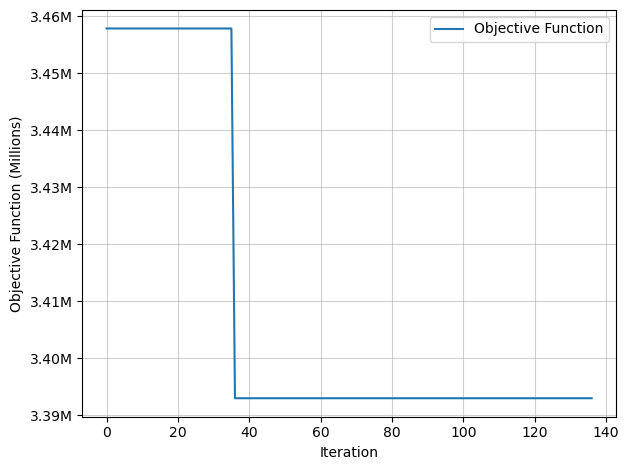

In [ ]:
best_hyperparams={}
best_hyperparams['MAX_ILS_ITERATIONS']=200
best_hyperparams['MAX_NO_IMPROVEMENT_ILS']=100
best_hyperparams['INITIAL_HEURISTIC']="sa_fcfs"
best_hyperparams['MAX_LS_ITERS_PER_CALL']=20
best_hyperparams['PERTURBATION_STRENGTH']=0.2

file_path="test_system_4.json"
processed_data=load_and_preprocess_data(file_path) 


s_best,cost=iterated_local_search_vis(processed_data, best_hyperparams['MAX_ILS_ITERATIONS'], 
                                      best_hyperparams['MAX_NO_IMPROVEMENT_ILS'],
                                      best_hyperparams['INITIAL_HEURISTIC'], 
                                      best_hyperparams['MAX_LS_ITERS_PER_CALL'],
                                      best_hyperparams['PERTURBATION_STRENGTH'])


df_cost=pd.DataFrame.from_dict(cost, orient='index', columns=['Objective Function'])
df_cost.reset_index(drop=True, inplace=True)



from matplotlib.ticker import FuncFormatter


fig, ax = plt.subplots()
df_cost.plot(y='Objective Function', ax=ax)
formatter = FuncFormatter(lambda x, pos: f'{x*1e-6:.2f}M')
ax.yaxis.set_major_formatter(formatter)
ax.set_ylabel('Objective Function (Millions)')
ax.set_xlabel('Iteration')
ax.grid(True,alpha=0.6)
plt.tight_layout()
plt.show()

NameError: name 'wilmar' is not defined

In [ ]:
# Main execution block (after loading all_problem_instances_data):

if all_problem_instances_data: # Proceed only if instances were loaded
    #create Optuna Study
    study = optuna.create_study(direction='minimize',sampler=optuna.samplers.TPESampler(seed=seed))

    objective_with_all_instances = partial(optuna_objective_for_ils,list_of_problem_data_sets=all_problem_instances_data)

    n_trials=30
    try:
        study.optimize(objective_with_all_instances, n_trials=n_trials) 
    except KeyboardInterrupt:
        print("Optuna study interrupted by user.")
    except Exception as e:
        print(f"An error occurred during Optuna optimization: {e}")
        import traceback
        traceback.print_exc()

    # Print the best results
    print("\nOptuna Study Summary:")
    print(f"Number of finished trials: {len(study.trials)}")

    if study.best_trial: # Check if any trial completed successfully
        best_hyperparams = study.best_trial.params
        optuna_minimized_objective = study.best_trial.value # This is the avg obj Optuna worked with

        print("\nBest hyperparameters found by Optuna:")
        for key, value in best_hyperparams.items():
            print(f"  {key}: {value}")
        print(f"Optuna's best average objective value: {optuna_minimized_objective:.2f}")

        print("\nRe-running ILS with best hyperparameters to collect final KPIs...")
        # Assuming 'all_problem_instances_data' is your list of preprocessed data for all instances
        # And 'instance_files' is the corresponding list of filenames
        final_run_kpis = run_ils_and_collect_kpis(all_problem_instances_data, best_hyperparams, instance_files)

        # Combine all information to save
        results_to_store = {
            "best_hyperparameters_from_optuna": best_hyperparams,
            "optuna_objective_for_best_params": optuna_minimized_objective,
            "final_run_aggregated_kpis": final_run_kpis
        }

        # Store in a JSON file
        output_filename = "results_and_kpis_3a.json"
        try:
            with open(output_filename, 'w') as f:
                json.dump(results_to_store, f, indent=4)
            print(f"\nSuccessfully saved results and KPIs to {output_filename}")
        except Exception as e:
            print(f"Error saving results to JSON: {e}")
            
        # Print a summary of final run KPIs
        print("\n--- Summary of Final Run with Best Hyperparameters ---")
        print(f"Total Execution Time: {final_run_kpis['total_execution_time_seconds']:.2f} seconds")
        print(f"Average Objective (on re-run): {final_run_kpis['average_objective_on_rerun']:.2f}")
        print(f"Total Energy Supplied (all instances): {final_run_kpis['total_energy_supplied_kwh_all_instances']:.2f} kWh")
        print(f"Successful runs / Total instances: {final_run_kpis['number_of_successful_runs']}/{final_run_kpis['number_of_instances_processed']}")

    else:
        print("Optuna study did not find a best trial. No KPIs to calculate or save.")


[I 2025-05-31 13:35:13,716] A new study created in memory with name: no-name-35a22577-5f5f-4c03-9a94-d4fb998852e8



Optuna Trial 0: Params: MaxIter=397, NoImprove=2, LS_Iter=34, PerturbStr=0.32
  Running ILS on instance 1/7...

ILS finished in 0.69 seconds.
Final best objective found by ILS: 1307521.04
    Instance 1 Objective: 1307521.04
  Running ILS on instance 2/7...

ILS finished in 1.72 seconds.
Final best objective found by ILS: 2455146.18
    Instance 2 Objective: 2455146.18
  Running ILS on instance 3/7...

ILS finished in 3.72 seconds.
Final best objective found by ILS: 2766948.46
    Instance 3 Objective: 2766948.46
  Running ILS on instance 4/7...

ILS finished in 4.80 seconds.
Final best objective found by ILS: 4071034.92
    Instance 4 Objective: 4071034.92
  Running ILS on instance 5/7...

ILS finished in 12.50 seconds.
Final best objective found by ILS: 3932988.53
    Instance 5 Objective: 3932988.53
  Running ILS on instance 6/7...

ILS finished in 25.51 seconds.
Final best objective found by ILS: 4262781.95
    Instance 6 Objective: 4262781.95
  Running ILS on instance 7/7...


[I 2025-05-31 13:36:59,124] Trial 0 finished with value: 3436112.9561864384 and parameters: {'MAX_ILS_ITERATIONS': 397, 'MAX_NO_IMPROVEMENT_ILS': 2, 'MAX_LS_ITERS_PER_CALL': 34, 'PERTURBATION_STRENGTH': 0.32464116476158356, 'INITIAL_HEURISTIC': 'pa_edf'}. Best is trial 0 with value: 3436112.9561864384.



ILS finished in 56.46 seconds.
Final best objective found by ILS: 5256369.61
    Instance 7 Objective: 5256369.61
Optuna Trial 0: Average Objective across 7 instances: 3436112.96

Optuna Trial 1: Params: MaxIter=139, NoImprove=39, LS_Iter=12, PerturbStr=0.13
  Running ILS on instance 1/7...

ILS Iteration: 10 out of: 139

ILS Iteration: 20 out of: 139

ILS Iteration: 30 out of: 139

ILS finished in 10.00 seconds.
Final best objective found by ILS: 1295549.34
    Instance 1 Objective: 1295549.34
  Running ILS on instance 2/7...

ILS Iteration: 10 out of: 139

ILS Iteration: 20 out of: 139

ILS Iteration: 30 out of: 139

ILS Iteration: 40 out of: 139

ILS finished in 22.74 seconds.
Final best objective found by ILS: 2271239.32
    Instance 2 Objective: 2271239.32
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 139

ILS Iteration: 20 out of: 139

ILS Iteration: 30 out of: 139

ILS Iteration: 40 out of: 139

ILS finished in 30.61 seconds.
Final best objective found by ILS: 264

[I 2025-05-31 14:02:42,366] Trial 1 finished with value: 3087685.9946853956 and parameters: {'MAX_ILS_ITERATIONS': 139, 'MAX_NO_IMPROVEMENT_ILS': 39, 'MAX_LS_ITERS_PER_CALL': 12, 'PERTURBATION_STRENGTH': 0.1265019442522031, 'INITIAL_HEURISTIC': 'sa_fcfs'}. Best is trial 1 with value: 3087685.9946853956.



ILS finished in 927.23 seconds.
Final best objective found by ILS: 4338061.72
    Instance 7 Objective: 4338061.72
Optuna Trial 1: Average Objective across 7 instances: 3087685.99

Optuna Trial 2: Params: MaxIter=51, NoImprove=26, LS_Iter=42, PerturbStr=0.28
  Running ILS on instance 1/7...

ILS Iteration: 10 out of: 51

ILS Iteration: 20 out of: 51

ILS finished in 10.45 seconds.
Final best objective found by ILS: 1307521.04
    Instance 1 Objective: 1307521.04
  Running ILS on instance 2/7...

ILS Iteration: 10 out of: 51

ILS Iteration: 20 out of: 51

ILS finished in 15.82 seconds.
Final best objective found by ILS: 2405732.40
    Instance 2 Objective: 2405732.40
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 51

ILS Iteration: 20 out of: 51

ILS finished in 25.03 seconds.
Final best objective found by ILS: 2671861.74
    Instance 3 Objective: 2671861.74
  Running ILS on instance 4/7...

ILS Iteration: 10 out of: 51

ILS Iteration: 20 out of: 51

ILS finished in 40.18 

[I 2025-05-31 14:23:43,878] Trial 2 finished with value: 3412622.250742341 and parameters: {'MAX_ILS_ITERATIONS': 51, 'MAX_NO_IMPROVEMENT_ILS': 26, 'MAX_LS_ITERS_PER_CALL': 42, 'PERTURBATION_STRENGTH': 0.28375782004881644, 'INITIAL_HEURISTIC': 'pa_edf'}. Best is trial 1 with value: 3087685.9946853956.



ILS finished in 742.03 seconds.
Final best objective found by ILS: 5256369.61
    Instance 7 Objective: 5256369.61
Optuna Trial 2: Average Objective across 7 instances: 3412622.25

Optuna Trial 3: Params: MaxIter=463, NoImprove=36, LS_Iter=29, PerturbStr=0.14
  Running ILS on instance 1/7...

ILS Iteration: 10 out of: 463

ILS Iteration: 20 out of: 463

ILS Iteration: 30 out of: 463

ILS finished in 12.96 seconds.
Final best objective found by ILS: 1295549.34
    Instance 1 Objective: 1295549.34
  Running ILS on instance 2/7...

ILS Iteration: 10 out of: 463

ILS Iteration: 20 out of: 463

ILS Iteration: 30 out of: 463

ILS Iteration: 40 out of: 463

ILS Iteration: 50 out of: 463

ILS finished in 34.24 seconds.
Final best objective found by ILS: 2297679.14
    Instance 2 Objective: 2297679.14
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 463

ILS Iteration: 20 out of: 463

ILS Iteration: 30 out of: 463

ILS finished in 38.38 seconds.
Final best objective found by ILS: 26

[I 2025-05-31 15:05:01,121] Trial 3 finished with value: 3082136.4229613286 and parameters: {'MAX_ILS_ITERATIONS': 463, 'MAX_NO_IMPROVEMENT_ILS': 36, 'MAX_LS_ITERS_PER_CALL': 29, 'PERTURBATION_STRENGTH': 0.1426510142804581, 'INITIAL_HEURISTIC': 'sa_fcfs'}. Best is trial 3 with value: 3082136.4229613286.



ILS finished in 1412.65 seconds.
Final best objective found by ILS: 4338061.72
    Instance 7 Objective: 4338061.72
Optuna Trial 3: Average Objective across 7 instances: 3082136.42

Optuna Trial 4: Params: MaxIter=249, NoImprove=22, LS_Iter=33, PerturbStr=0.25
  Running ILS on instance 1/7...

ILS Iteration: 10 out of: 249

ILS Iteration: 20 out of: 249

ILS finished in 7.43 seconds.
Final best objective found by ILS: 1307521.04
    Instance 1 Objective: 1307521.04
  Running ILS on instance 2/7...

ILS Iteration: 10 out of: 249

ILS Iteration: 20 out of: 249

ILS finished in 12.42 seconds.
Final best objective found by ILS: 2445828.27
    Instance 2 Objective: 2445828.27
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 249

ILS Iteration: 20 out of: 249

ILS finished in 23.73 seconds.
Final best objective found by ILS: 2774915.68
    Instance 3 Objective: 2774915.68
  Running ILS on instance 4/7...

ILS Iteration: 10 out of: 249

ILS Iteration: 20 out of: 249

ILS finished 

[I 2025-05-31 15:21:49,744] Trial 4 finished with value: 3422706.4860996464 and parameters: {'MAX_ILS_ITERATIONS': 249, 'MAX_NO_IMPROVEMENT_ILS': 22, 'MAX_LS_ITERS_PER_CALL': 33, 'PERTURBATION_STRENGTH': 0.2539414727663173, 'INITIAL_HEURISTIC': 'pa_edf'}. Best is trial 3 with value: 3082136.4229613286.



ILS finished in 598.52 seconds.
Final best objective found by ILS: 5256369.61
    Instance 7 Objective: 5256369.61
Optuna Trial 4: Average Objective across 7 instances: 3422706.49

Optuna Trial 5: Params: MaxIter=413, NoImprove=27, LS_Iter=46, PerturbStr=0.20
  Running ILS on instance 1/7...

ILS Iteration: 10 out of: 413

ILS Iteration: 20 out of: 413

ILS finished in 10.89 seconds.
Final best objective found by ILS: 1295549.34
    Instance 1 Objective: 1295549.34
  Running ILS on instance 2/7...

ILS Iteration: 10 out of: 413

ILS Iteration: 20 out of: 413

ILS finished in 16.90 seconds.
Final best objective found by ILS: 2307104.97
    Instance 2 Objective: 2307104.97
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 413

ILS Iteration: 20 out of: 413

ILS finished in 37.68 seconds.
Final best objective found by ILS: 2567834.48
    Instance 3 Objective: 2567834.48
  Running ILS on instance 4/7...

ILS Iteration: 10 out of: 413

ILS Iteration: 20 out of: 413

ILS finished 

[I 2025-05-31 15:55:15,367] Trial 5 finished with value: 3091369.5570286927 and parameters: {'MAX_ILS_ITERATIONS': 413, 'MAX_NO_IMPROVEMENT_ILS': 27, 'MAX_LS_ITERS_PER_CALL': 46, 'PERTURBATION_STRENGTH': 0.1957708266965636, 'INITIAL_HEURISTIC': 'sa_fcfs'}. Best is trial 3 with value: 3082136.4229613286.



ILS finished in 1201.83 seconds.
Final best objective found by ILS: 4338061.72
    Instance 7 Objective: 4338061.72
Optuna Trial 5: Average Objective across 7 instances: 3091369.56

Optuna Trial 6: Params: MaxIter=101, NoImprove=42, LS_Iter=7, PerturbStr=0.29
  Running ILS on instance 1/7...

ILS Iteration: 10 out of: 101

ILS Iteration: 20 out of: 101

ILS Iteration: 30 out of: 101

ILS Iteration: 40 out of: 101

ILS finished in 8.48 seconds.
Final best objective found by ILS: 1295549.34
    Instance 1 Objective: 1295549.34
  Running ILS on instance 2/7...

ILS Iteration: 10 out of: 101

ILS Iteration: 20 out of: 101

ILS Iteration: 30 out of: 101

ILS Iteration: 40 out of: 101

ILS finished in 17.95 seconds.
Final best objective found by ILS: 2306457.18
    Instance 2 Objective: 2306457.18
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 101

ILS Iteration: 20 out of: 101

ILS Iteration: 30 out of: 101

ILS Iteration: 40 out of: 101

ILS finished in 25.70 seconds.
Final b

[I 2025-05-31 16:12:34,148] Trial 6 finished with value: 3103005.2593983794 and parameters: {'MAX_ILS_ITERATIONS': 101, 'MAX_NO_IMPROVEMENT_ILS': 42, 'MAX_LS_ITERS_PER_CALL': 7, 'PERTURBATION_STRENGTH': 0.28788614449341776, 'INITIAL_HEURISTIC': 'sa_fcfs'}. Best is trial 3 with value: 3082136.4229613286.



ILS finished in 590.28 seconds.
Final best objective found by ILS: 4338061.72
    Instance 7 Objective: 4338061.72
Optuna Trial 6: Average Objective across 7 instances: 3103005.26

Optuna Trial 7: Params: MaxIter=139, NoImprove=43, LS_Iter=21, PerturbStr=0.33
  Running ILS on instance 1/7...

ILS Iteration: 10 out of: 139

ILS Iteration: 20 out of: 139

ILS Iteration: 30 out of: 139

ILS Iteration: 40 out of: 139

ILS finished in 12.13 seconds.
Final best objective found by ILS: 1295549.34
    Instance 1 Objective: 1295549.34
  Running ILS on instance 2/7...

ILS Iteration: 10 out of: 139

ILS Iteration: 20 out of: 139

ILS Iteration: 30 out of: 139

ILS Iteration: 40 out of: 139

ILS Iteration: 50 out of: 139

ILS Iteration: 60 out of: 139

ILS finished in 36.42 seconds.
Final best objective found by ILS: 2269003.52
    Instance 2 Objective: 2269003.52
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 139

ILS Iteration: 20 out of: 139

ILS Iteration: 30 out of: 139

ILS It

[I 2025-05-31 16:41:20,869] Trial 7 finished with value: 3103623.820918508 and parameters: {'MAX_ILS_ITERATIONS': 139, 'MAX_NO_IMPROVEMENT_ILS': 43, 'MAX_LS_ITERS_PER_CALL': 21, 'PERTURBATION_STRENGTH': 0.3263943074589572, 'INITIAL_HEURISTIC': 'sa_fcfs'}. Best is trial 3 with value: 3082136.4229613286.



ILS finished in 1015.45 seconds.
Final best objective found by ILS: 4338061.72
    Instance 7 Objective: 4338061.72
Optuna Trial 7: Average Objective across 7 instances: 3103623.82

Optuna Trial 8: Params: MaxIter=196, NoImprove=9, LS_Iter=23, PerturbStr=0.13
  Running ILS on instance 1/7...

ILS finished in 2.86 seconds.
Final best objective found by ILS: 1307521.04
    Instance 1 Objective: 1307521.04
  Running ILS on instance 2/7...

ILS Iteration: 10 out of: 196

ILS finished in 8.36 seconds.
Final best objective found by ILS: 2421527.25
    Instance 2 Objective: 2421527.25
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 196

ILS Iteration: 20 out of: 196

ILS finished in 16.50 seconds.
Final best objective found by ILS: 2767444.40
    Instance 3 Objective: 2767444.40
  Running ILS on instance 4/7...

ILS finished in 15.72 seconds.
Final best objective found by ILS: 4030436.42
    Instance 4 Objective: 4030436.42
  Running ILS on instance 5/7...

ILS Iteration: 10 out 

[I 2025-05-31 16:48:58,401] Trial 8 finished with value: 3415987.1950994073 and parameters: {'MAX_ILS_ITERATIONS': 196, 'MAX_NO_IMPROVEMENT_ILS': 9, 'MAX_LS_ITERS_PER_CALL': 23, 'PERTURBATION_STRENGTH': 0.1280381123675951, 'INITIAL_HEURISTIC': 'pa_edf'}. Best is trial 3 with value: 3082136.4229613286.



ILS finished in 258.17 seconds.
Final best objective found by ILS: 5256369.61
    Instance 7 Objective: 5256369.61
Optuna Trial 8: Average Objective across 7 instances: 3415987.20

Optuna Trial 9: Params: MaxIter=223, NoImprove=48, LS_Iter=50, PerturbStr=0.24
  Running ILS on instance 1/7...

ILS Iteration: 10 out of: 223

ILS Iteration: 20 out of: 223

ILS Iteration: 30 out of: 223

ILS Iteration: 40 out of: 223

ILS finished in 21.09 seconds.
Final best objective found by ILS: 1307521.04
    Instance 1 Objective: 1307521.04
  Running ILS on instance 2/7...

ILS Iteration: 10 out of: 223

ILS Iteration: 20 out of: 223

ILS Iteration: 30 out of: 223

ILS Iteration: 40 out of: 223

ILS finished in 32.31 seconds.
Final best objective found by ILS: 2432241.28
    Instance 2 Objective: 2432241.28
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 223

ILS Iteration: 20 out of: 223

ILS Iteration: 30 out of: 223

ILS Iteration: 40 out of: 223

ILS Iteration: 50 out of: 223

ILS It

[I 2025-05-31 17:31:37,975] Trial 9 finished with value: 3428725.419769732 and parameters: {'MAX_ILS_ITERATIONS': 223, 'MAX_NO_IMPROVEMENT_ILS': 48, 'MAX_LS_ITERS_PER_CALL': 50, 'PERTURBATION_STRENGTH': 0.23689136412843526, 'INITIAL_HEURISTIC': 'pa_edf'}. Best is trial 3 with value: 3082136.4229613286.



ILS finished in 1401.65 seconds.
Final best objective found by ILS: 5256369.61
    Instance 7 Objective: 5256369.61
Optuna Trial 9: Average Objective across 7 instances: 3428725.42

Optuna Trial 10: Params: MaxIter=476, NoImprove=33, LS_Iter=17, PerturbStr=0.18
  Running ILS on instance 1/7...

ILS Iteration: 10 out of: 476

ILS Iteration: 20 out of: 476

ILS Iteration: 30 out of: 476

ILS finished in 8.84 seconds.
Final best objective found by ILS: 1295549.34
    Instance 1 Objective: 1295549.34
  Running ILS on instance 2/7...

ILS Iteration: 10 out of: 476

ILS Iteration: 20 out of: 476

ILS Iteration: 30 out of: 476

ILS finished in 18.32 seconds.
Final best objective found by ILS: 2286323.29
    Instance 2 Objective: 2286323.29
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 476

ILS Iteration: 20 out of: 476

ILS Iteration: 30 out of: 476

ILS Iteration: 40 out of: 476

ILS Iteration: 50 out of: 476

ILS finished in 47.26 seconds.
Final best objective found by ILS: 2

[I 2025-05-31 17:56:05,716] Trial 10 finished with value: 3081301.0674915365 and parameters: {'MAX_ILS_ITERATIONS': 476, 'MAX_NO_IMPROVEMENT_ILS': 33, 'MAX_LS_ITERS_PER_CALL': 17, 'PERTURBATION_STRENGTH': 0.18132481460771827, 'INITIAL_HEURISTIC': 'sa_fcfs'}. Best is trial 10 with value: 3081301.0674915365.



ILS finished in 880.12 seconds.
Final best objective found by ILS: 4338061.72
    Instance 7 Objective: 4338061.72
Optuna Trial 10: Average Objective across 7 instances: 3081301.07

Optuna Trial 11: Params: MaxIter=494, NoImprove=33, LS_Iter=16, PerturbStr=0.18
  Running ILS on instance 1/7...

ILS Iteration: 10 out of: 494

ILS Iteration: 20 out of: 494

ILS Iteration: 30 out of: 494

ILS finished in 8.64 seconds.
Final best objective found by ILS: 1295549.34
    Instance 1 Objective: 1295549.34
  Running ILS on instance 2/7...

ILS Iteration: 10 out of: 494

ILS Iteration: 20 out of: 494

ILS Iteration: 30 out of: 494

ILS finished in 17.25 seconds.
Final best objective found by ILS: 2249192.56
    Instance 2 Objective: 2249192.56
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 494

ILS Iteration: 20 out of: 494

ILS Iteration: 30 out of: 494

ILS finished in 26.04 seconds.
Final best objective found by ILS: 2660623.35
    Instance 3 Objective: 2660623.35
  Running ILS o

[I 2025-05-31 18:19:36,037] Trial 11 finished with value: 3091736.3312146985 and parameters: {'MAX_ILS_ITERATIONS': 494, 'MAX_NO_IMPROVEMENT_ILS': 33, 'MAX_LS_ITERS_PER_CALL': 16, 'PERTURBATION_STRENGTH': 0.17743176455838375, 'INITIAL_HEURISTIC': 'sa_fcfs'}. Best is trial 10 with value: 3081301.0674915365.



ILS finished in 871.47 seconds.
Final best objective found by ILS: 4338061.72
    Instance 7 Objective: 4338061.72
Optuna Trial 11: Average Objective across 7 instances: 3091736.33

Optuna Trial 12: Params: MaxIter=349, NoImprove=18, LS_Iter=29, PerturbStr=0.18
  Running ILS on instance 1/7...

ILS Iteration: 10 out of: 349

ILS finished in 6.55 seconds.
Final best objective found by ILS: 1295549.34
    Instance 1 Objective: 1295549.34
  Running ILS on instance 2/7...

ILS Iteration: 10 out of: 349

ILS finished in 10.35 seconds.
Final best objective found by ILS: 2295731.68
    Instance 2 Objective: 2295731.68
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 349

ILS finished in 16.30 seconds.
Final best objective found by ILS: 2647060.19
    Instance 3 Objective: 2647060.19
  Running ILS on instance 4/7...

ILS Iteration: 10 out of: 349

ILS finished in 37.94 seconds.
Final best objective found by ILS: 3457845.43
    Instance 4 Objective: 3457845.43
  Running ILS on insta

[I 2025-05-31 18:37:30,516] Trial 12 finished with value: 3104157.931448261 and parameters: {'MAX_ILS_ITERATIONS': 349, 'MAX_NO_IMPROVEMENT_ILS': 18, 'MAX_LS_ITERS_PER_CALL': 29, 'PERTURBATION_STRENGTH': 0.1832894331869776, 'INITIAL_HEURISTIC': 'sa_fcfs'}. Best is trial 10 with value: 3081301.0674915365.



ILS finished in 679.39 seconds.
Final best objective found by ILS: 4338061.72
    Instance 7 Objective: 4338061.72
Optuna Trial 12: Average Objective across 7 instances: 3104157.93

Optuna Trial 13: Params: MaxIter=492, NoImprove=34, LS_Iter=18, PerturbStr=0.40
  Running ILS on instance 1/7...

ILS Iteration: 10 out of: 492

ILS Iteration: 20 out of: 492

ILS Iteration: 30 out of: 492

ILS finished in 8.90 seconds.
Final best objective found by ILS: 1295549.34
    Instance 1 Objective: 1295549.34
  Running ILS on instance 2/7...

ILS Iteration: 10 out of: 492

ILS Iteration: 20 out of: 492

ILS Iteration: 30 out of: 492

ILS finished in 16.62 seconds.
Final best objective found by ILS: 2310507.43
    Instance 2 Objective: 2310507.43
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 492

ILS Iteration: 20 out of: 492

ILS Iteration: 30 out of: 492

ILS finished in 28.39 seconds.
Final best objective found by ILS: 2661252.61
    Instance 3 Objective: 2661252.61
  Running ILS o

[I 2025-05-31 18:56:05,434] Trial 13 finished with value: 3108296.2396939495 and parameters: {'MAX_ILS_ITERATIONS': 492, 'MAX_NO_IMPROVEMENT_ILS': 34, 'MAX_LS_ITERS_PER_CALL': 18, 'PERTURBATION_STRENGTH': 0.39678480649940007, 'INITIAL_HEURISTIC': 'sa_fcfs'}. Best is trial 10 with value: 3081301.0674915365.



ILS finished in 627.76 seconds.
Final best objective found by ILS: 4338061.72
    Instance 7 Objective: 4338061.72
Optuna Trial 13: Average Objective across 7 instances: 3108296.24

Optuna Trial 14: Params: MaxIter=327, NoImprove=32, LS_Iter=27, PerturbStr=0.10
  Running ILS on instance 1/7...

ILS Iteration: 10 out of: 327

ILS Iteration: 20 out of: 327

ILS Iteration: 30 out of: 327

ILS Iteration: 40 out of: 327

ILS finished in 14.55 seconds.
Final best objective found by ILS: 1294536.17
    Instance 1 Objective: 1294536.17
  Running ILS on instance 2/7...

ILS Iteration: 10 out of: 327

ILS Iteration: 20 out of: 327

ILS Iteration: 30 out of: 327

ILS finished in 22.76 seconds.
Final best objective found by ILS: 2246082.99
    Instance 2 Objective: 2246082.99
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 327

ILS Iteration: 20 out of: 327

ILS Iteration: 30 out of: 327

ILS finished in 31.20 seconds.
Final best objective found by ILS: 2617190.42
    Instance 3 Objec

[I 2025-05-31 19:30:28,563] Trial 14 finished with value: 3082594.138017155 and parameters: {'MAX_ILS_ITERATIONS': 327, 'MAX_NO_IMPROVEMENT_ILS': 32, 'MAX_LS_ITERS_PER_CALL': 27, 'PERTURBATION_STRENGTH': 0.10134559311467703, 'INITIAL_HEURISTIC': 'sa_fcfs'}. Best is trial 10 with value: 3081301.0674915365.



ILS finished in 1320.76 seconds.
Final best objective found by ILS: 4338061.72
    Instance 7 Objective: 4338061.72
Optuna Trial 14: Average Objective across 7 instances: 3082594.14

Optuna Trial 15: Params: MaxIter=435, NoImprove=13, LS_Iter=5, PerturbStr=0.16
  Running ILS on instance 1/7...

ILS Iteration: 10 out of: 435

ILS finished in 2.31 seconds.
Final best objective found by ILS: 1295549.34
    Instance 1 Objective: 1295549.34
  Running ILS on instance 2/7...

ILS Iteration: 10 out of: 435

ILS finished in 4.90 seconds.
Final best objective found by ILS: 2254233.90
    Instance 2 Objective: 2254233.90
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 435

ILS finished in 9.72 seconds.
Final best objective found by ILS: 2608591.01
    Instance 3 Objective: 2608591.01
  Running ILS on instance 4/7...

ILS Iteration: 10 out of: 435

ILS finished in 18.72 seconds.
Final best objective found by ILS: 3333408.04
    Instance 4 Objective: 3333408.04
  Running ILS on instanc

[I 2025-05-31 19:36:05,601] Trial 15 finished with value: 3066629.268805873 and parameters: {'MAX_ILS_ITERATIONS': 435, 'MAX_NO_IMPROVEMENT_ILS': 13, 'MAX_LS_ITERS_PER_CALL': 5, 'PERTURBATION_STRENGTH': 0.15570058557209682, 'INITIAL_HEURISTIC': 'sa_fcfs'}. Best is trial 15 with value: 3066629.268805873.



ILS finished in 180.10 seconds.
Final best objective found by ILS: 4338061.72
    Instance 7 Objective: 4338061.72
Optuna Trial 15: Average Objective across 7 instances: 3066629.27

Optuna Trial 16: Params: MaxIter=419, NoImprove=14, LS_Iter=6, PerturbStr=0.21
  Running ILS on instance 1/7...

ILS Iteration: 10 out of: 419

ILS finished in 2.74 seconds.
Final best objective found by ILS: 1295549.34
    Instance 1 Objective: 1295549.34
  Running ILS on instance 2/7...

ILS Iteration: 10 out of: 419

ILS finished in 6.12 seconds.
Final best objective found by ILS: 2262454.11
    Instance 2 Objective: 2262454.11
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 419

ILS finished in 8.11 seconds.
Final best objective found by ILS: 2674602.73
    Instance 3 Objective: 2674602.73
  Running ILS on instance 4/7...

ILS Iteration: 10 out of: 419

ILS finished in 22.27 seconds.
Final best objective found by ILS: 3349349.63
    Instance 4 Objective: 3349349.63
  Running ILS on instance

[I 2025-05-31 19:42:06,667] Trial 16 finished with value: 3087839.240494675 and parameters: {'MAX_ILS_ITERATIONS': 419, 'MAX_NO_IMPROVEMENT_ILS': 14, 'MAX_LS_ITERS_PER_CALL': 6, 'PERTURBATION_STRENGTH': 0.21377681803248016, 'INITIAL_HEURISTIC': 'sa_fcfs'}. Best is trial 15 with value: 3066629.268805873.



ILS finished in 206.75 seconds.
Final best objective found by ILS: 4338061.72
    Instance 7 Objective: 4338061.72
Optuna Trial 16: Average Objective across 7 instances: 3087839.24

Optuna Trial 17: Params: MaxIter=315, NoImprove=8, LS_Iter=12, PerturbStr=0.16
  Running ILS on instance 1/7...

ILS finished in 1.99 seconds.
Final best objective found by ILS: 1295549.34
    Instance 1 Objective: 1295549.34
  Running ILS on instance 2/7...

ILS finished in 4.29 seconds.
Final best objective found by ILS: 2260268.28
    Instance 2 Objective: 2260268.28
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 315

ILS finished in 8.71 seconds.
Final best objective found by ILS: 2616129.04
    Instance 3 Objective: 2616129.04
  Running ILS on instance 4/7...

ILS finished in 11.87 seconds.
Final best objective found by ILS: 3457845.43
    Instance 4 Objective: 3457845.43
  Running ILS on instance 5/7...

ILS finished in 27.64 seconds.
Final best objective found by ILS: 3779940.44
    Ins

[I 2025-05-31 19:47:36,869] Trial 17 finished with value: 3093143.6163679264 and parameters: {'MAX_ILS_ITERATIONS': 315, 'MAX_NO_IMPROVEMENT_ILS': 8, 'MAX_LS_ITERS_PER_CALL': 12, 'PERTURBATION_STRENGTH': 0.15736752874808826, 'INITIAL_HEURISTIC': 'sa_fcfs'}. Best is trial 15 with value: 3066629.268805873.



ILS finished in 188.76 seconds.
Final best objective found by ILS: 4338061.72
    Instance 7 Objective: 4338061.72
Optuna Trial 17: Average Objective across 7 instances: 3093143.62

Optuna Trial 18: Params: MaxIter=384, NoImprove=17, LS_Iter=11, PerturbStr=0.22
  Running ILS on instance 1/7...

ILS Iteration: 10 out of: 384

ILS finished in 3.84 seconds.
Final best objective found by ILS: 1295549.34
    Instance 1 Objective: 1295549.34
  Running ILS on instance 2/7...

ILS Iteration: 10 out of: 384

ILS finished in 8.57 seconds.
Final best objective found by ILS: 2287221.97
    Instance 2 Objective: 2287221.97
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 384

ILS Iteration: 20 out of: 384

ILS finished in 15.04 seconds.
Final best objective found by ILS: 2657052.51
    Instance 3 Objective: 2657052.51
  Running ILS on instance 4/7...

ILS Iteration: 10 out of: 384

ILS finished in 24.62 seconds.
Final best objective found by ILS: 3457845.43
    Instance 4 Objective: 345

[I 2025-05-31 19:56:59,811] Trial 18 finished with value: 3104369.7312309477 and parameters: {'MAX_ILS_ITERATIONS': 384, 'MAX_NO_IMPROVEMENT_ILS': 17, 'MAX_LS_ITERS_PER_CALL': 11, 'PERTURBATION_STRENGTH': 0.22350543390336863, 'INITIAL_HEURISTIC': 'sa_fcfs'}. Best is trial 15 with value: 3066629.268805873.



ILS finished in 329.56 seconds.
Final best objective found by ILS: 4338061.72
    Instance 7 Objective: 4338061.72
Optuna Trial 18: Average Objective across 7 instances: 3104369.73

Optuna Trial 19: Params: MaxIter=447, NoImprove=3, LS_Iter=15, PerturbStr=0.16
  Running ILS on instance 1/7...

ILS finished in 1.02 seconds.
Final best objective found by ILS: 1295549.34
    Instance 1 Objective: 1295549.34
  Running ILS on instance 2/7...

ILS finished in 2.41 seconds.
Final best objective found by ILS: 2273914.64
    Instance 2 Objective: 2273914.64
  Running ILS on instance 3/7...

ILS finished in 2.71 seconds.
Final best objective found by ILS: 2674602.73
    Instance 3 Objective: 2674602.73
  Running ILS on instance 4/7...

ILS finished in 5.71 seconds.
Final best objective found by ILS: 3457845.43
    Instance 4 Objective: 3457845.43
  Running ILS on instance 5/7...

ILS finished in 13.67 seconds.
Final best objective found by ILS: 3779940.44
    Instance 5 Objective: 3779940.44
  

[I 2025-05-31 19:59:42,653] Trial 19 finished with value: 3104975.858866107 and parameters: {'MAX_ILS_ITERATIONS': 447, 'MAX_NO_IMPROVEMENT_ILS': 3, 'MAX_LS_ITERS_PER_CALL': 15, 'PERTURBATION_STRENGTH': 0.1649567039702099, 'INITIAL_HEURISTIC': 'sa_fcfs'}. Best is trial 15 with value: 3066629.268805873.



ILS finished in 102.64 seconds.
Final best objective found by ILS: 4338061.72
    Instance 7 Objective: 4338061.72
Optuna Trial 19: Average Objective across 7 instances: 3104975.86

Optuna Trial 20: Params: MaxIter=285, NoImprove=22, LS_Iter=5, PerturbStr=0.11
  Running ILS on instance 1/7...

ILS Iteration: 10 out of: 285

ILS Iteration: 20 out of: 285

ILS finished in 3.91 seconds.
Final best objective found by ILS: 1295549.34
    Instance 1 Objective: 1295549.34
  Running ILS on instance 2/7...

ILS Iteration: 10 out of: 285

ILS Iteration: 20 out of: 285

ILS finished in 8.77 seconds.
Final best objective found by ILS: 2286859.73
    Instance 2 Objective: 2286859.73
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 285

ILS Iteration: 20 out of: 285

ILS finished in 14.04 seconds.
Final best objective found by ILS: 2569454.63
    Instance 3 Objective: 2569454.63
  Running ILS on instance 4/7...

ILS Iteration: 10 out of: 285

ILS Iteration: 20 out of: 285

ILS finished i

[I 2025-05-31 20:09:15,715] Trial 20 finished with value: 3080148.8462157473 and parameters: {'MAX_ILS_ITERATIONS': 285, 'MAX_NO_IMPROVEMENT_ILS': 22, 'MAX_LS_ITERS_PER_CALL': 5, 'PERTURBATION_STRENGTH': 0.10590227413641026, 'INITIAL_HEURISTIC': 'sa_fcfs'}. Best is trial 15 with value: 3066629.268805873.



ILS finished in 312.45 seconds.
Final best objective found by ILS: 4338061.72
    Instance 7 Objective: 4338061.72
Optuna Trial 20: Average Objective across 7 instances: 3080148.85

Optuna Trial 21: Params: MaxIter=291, NoImprove=23, LS_Iter=5, PerturbStr=0.10
  Running ILS on instance 1/7...

ILS Iteration: 10 out of: 291

ILS Iteration: 20 out of: 291

ILS Iteration: 30 out of: 291

ILS Iteration: 40 out of: 291

ILS Iteration: 50 out of: 291

ILS finished in 9.52 seconds.
Final best objective found by ILS: 1291091.23
    Instance 1 Objective: 1291091.23
  Running ILS on instance 2/7...

ILS Iteration: 10 out of: 291

ILS Iteration: 20 out of: 291

ILS finished in 10.44 seconds.
Final best objective found by ILS: 2266825.33
    Instance 2 Objective: 2266825.33
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 291

ILS Iteration: 20 out of: 291

ILS finished in 15.88 seconds.
Final best objective found by ILS: 2650949.17
    Instance 3 Objective: 2650949.17
  Running ILS on

[I 2025-05-31 20:19:20,940] Trial 21 finished with value: 3096985.0250192615 and parameters: {'MAX_ILS_ITERATIONS': 291, 'MAX_NO_IMPROVEMENT_ILS': 23, 'MAX_LS_ITERS_PER_CALL': 5, 'PERTURBATION_STRENGTH': 0.1015344602723092, 'INITIAL_HEURISTIC': 'sa_fcfs'}. Best is trial 15 with value: 3066629.268805873.



ILS finished in 327.47 seconds.
Final best objective found by ILS: 4338061.72
    Instance 7 Objective: 4338061.72
Optuna Trial 21: Average Objective across 7 instances: 3096985.03

Optuna Trial 22: Params: MaxIter=346, NoImprove=12, LS_Iter=9, PerturbStr=0.14
  Running ILS on instance 1/7...

ILS Iteration: 10 out of: 346

ILS Iteration: 20 out of: 346

ILS finished in 4.98 seconds.
Final best objective found by ILS: 1292875.49
    Instance 1 Objective: 1292875.49
  Running ILS on instance 2/7...

ILS Iteration: 10 out of: 346

ILS finished in 6.15 seconds.
Final best objective found by ILS: 2237937.26
    Instance 2 Objective: 2237937.26
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 346

ILS finished in 10.93 seconds.
Final best objective found by ILS: 2669708.60
    Instance 3 Objective: 2669708.60
  Running ILS on instance 4/7...

ILS Iteration: 10 out of: 346

ILS finished in 16.36 seconds.
Final best objective found by ILS: 3457845.43
    Instance 4 Objective: 3457

[I 2025-05-31 20:26:52,908] Trial 22 finished with value: 3090960.841943893 and parameters: {'MAX_ILS_ITERATIONS': 346, 'MAX_NO_IMPROVEMENT_ILS': 12, 'MAX_LS_ITERS_PER_CALL': 9, 'PERTURBATION_STRENGTH': 0.13681108014166607, 'INITIAL_HEURISTIC': 'sa_fcfs'}. Best is trial 15 with value: 3066629.268805873.



ILS finished in 231.42 seconds.
Final best objective found by ILS: 4338061.72
    Instance 7 Objective: 4338061.72
Optuna Trial 22: Average Objective across 7 instances: 3090960.84

Optuna Trial 23: Params: MaxIter=451, NoImprove=29, LS_Iter=5, PerturbStr=0.21
  Running ILS on instance 1/7...

ILS Iteration: 10 out of: 451

ILS Iteration: 20 out of: 451

ILS finished in 5.57 seconds.
Final best objective found by ILS: 1295549.34
    Instance 1 Objective: 1295549.34
  Running ILS on instance 2/7...

ILS Iteration: 10 out of: 451

ILS Iteration: 20 out of: 451

ILS Iteration: 30 out of: 451

ILS finished in 11.32 seconds.
Final best objective found by ILS: 2297045.16
    Instance 2 Objective: 2297045.16
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 451

ILS Iteration: 20 out of: 451

ILS Iteration: 30 out of: 451

ILS finished in 18.74 seconds.
Final best objective found by ILS: 2609470.37
    Instance 3 Objective: 2609470.37
  Running ILS on instance 4/7...

ILS Iteration

[I 2025-05-31 20:38:51,833] Trial 23 finished with value: 3092371.452112038 and parameters: {'MAX_ILS_ITERATIONS': 451, 'MAX_NO_IMPROVEMENT_ILS': 29, 'MAX_LS_ITERS_PER_CALL': 5, 'PERTURBATION_STRENGTH': 0.20724014858307882, 'INITIAL_HEURISTIC': 'sa_fcfs'}. Best is trial 15 with value: 3066629.268805873.



ILS finished in 373.62 seconds.
Final best objective found by ILS: 4338061.72
    Instance 7 Objective: 4338061.72
Optuna Trial 23: Average Objective across 7 instances: 3092371.45

Optuna Trial 24: Params: MaxIter=373, NoImprove=19, LS_Iter=20, PerturbStr=0.15
  Running ILS on instance 1/7...

ILS Iteration: 10 out of: 373

ILS finished in 5.51 seconds.
Final best objective found by ILS: 1295549.34
    Instance 1 Objective: 1295549.34
  Running ILS on instance 2/7...

ILS Iteration: 10 out of: 373

ILS finished in 10.79 seconds.
Final best objective found by ILS: 2268768.21
    Instance 2 Objective: 2268768.21
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 373

ILS Iteration: 20 out of: 373

ILS finished in 18.68 seconds.
Final best objective found by ILS: 2576232.42
    Instance 3 Objective: 2576232.42
  Running ILS on instance 4/7...

ILS Iteration: 10 out of: 373

ILS Iteration: 20 out of: 373

ILS finished in 52.83 seconds.
Final best objective found by ILS: 3418838.

[I 2025-05-31 20:57:55,216] Trial 24 finished with value: 3076485.2770566726 and parameters: {'MAX_ILS_ITERATIONS': 373, 'MAX_NO_IMPROVEMENT_ILS': 19, 'MAX_LS_ITERS_PER_CALL': 20, 'PERTURBATION_STRENGTH': 0.1527763201377205, 'INITIAL_HEURISTIC': 'sa_fcfs'}. Best is trial 15 with value: 3066629.268805873.



ILS finished in 622.52 seconds.
Final best objective found by ILS: 4338061.72
    Instance 7 Objective: 4338061.72
Optuna Trial 24: Average Objective across 7 instances: 3076485.28

Optuna Trial 25: Params: MaxIter=368, NoImprove=20, LS_Iter=23, PerturbStr=0.12
  Running ILS on instance 1/7...

ILS Iteration: 10 out of: 368

ILS finished in 5.98 seconds.
Final best objective found by ILS: 1295549.34
    Instance 1 Objective: 1295549.34
  Running ILS on instance 2/7...

ILS Iteration: 10 out of: 368

ILS Iteration: 20 out of: 368

ILS finished in 13.42 seconds.
Final best objective found by ILS: 2308588.60
    Instance 2 Objective: 2308588.60
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 368

ILS Iteration: 20 out of: 368

ILS Iteration: 30 out of: 368

ILS finished in 30.50 seconds.
Final best objective found by ILS: 2622080.92
    Instance 3 Objective: 2622080.92
  Running ILS on instance 4/7...

ILS Iteration: 10 out of: 368

ILS Iteration: 20 out of: 368

ILS finished

[I 2025-05-31 21:18:34,498] Trial 25 finished with value: 3087747.9579131156 and parameters: {'MAX_ILS_ITERATIONS': 368, 'MAX_NO_IMPROVEMENT_ILS': 20, 'MAX_LS_ITERS_PER_CALL': 23, 'PERTURBATION_STRENGTH': 0.11598033696262101, 'INITIAL_HEURISTIC': 'sa_fcfs'}. Best is trial 15 with value: 3066629.268805873.



ILS finished in 742.54 seconds.
Final best objective found by ILS: 4338061.72
    Instance 7 Objective: 4338061.72
Optuna Trial 25: Average Objective across 7 instances: 3087747.96

Optuna Trial 26: Params: MaxIter=280, NoImprove=15, LS_Iter=9, PerturbStr=0.15
  Running ILS on instance 1/7...

ILS Iteration: 10 out of: 280

ILS finished in 3.28 seconds.
Final best objective found by ILS: 1307521.04
    Instance 1 Objective: 1307521.04
  Running ILS on instance 2/7...

ILS Iteration: 10 out of: 280

ILS finished in 7.00 seconds.
Final best objective found by ILS: 2435975.14
    Instance 2 Objective: 2435975.14
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 280

ILS finished in 9.65 seconds.
Final best objective found by ILS: 2775390.37
    Instance 3 Objective: 2775390.37
  Running ILS on instance 4/7...

ILS Iteration: 10 out of: 280

ILS Iteration: 20 out of: 280

ILS finished in 23.65 seconds.
Final best objective found by ILS: 4058861.10
    Instance 4 Objective: 40588

[I 2025-05-31 21:25:25,438] Trial 26 finished with value: 3423017.560417303 and parameters: {'MAX_ILS_ITERATIONS': 280, 'MAX_NO_IMPROVEMENT_ILS': 15, 'MAX_LS_ITERS_PER_CALL': 9, 'PERTURBATION_STRENGTH': 0.1517873929775107, 'INITIAL_HEURISTIC': 'pa_edf'}. Best is trial 15 with value: 3066629.268805873.



ILS finished in 222.12 seconds.
Final best objective found by ILS: 5256369.61
    Instance 7 Objective: 5256369.61
Optuna Trial 26: Average Objective across 7 instances: 3423017.56

Optuna Trial 27: Params: MaxIter=247, NoImprove=11, LS_Iter=20, PerturbStr=0.16
  Running ILS on instance 1/7...

ILS Iteration: 10 out of: 247

ILS finished in 3.36 seconds.
Final best objective found by ILS: 1295549.34
    Instance 1 Objective: 1295549.34
  Running ILS on instance 2/7...

ILS Iteration: 10 out of: 247

ILS finished in 7.66 seconds.
Final best objective found by ILS: 2282195.40
    Instance 2 Objective: 2282195.40
  Running ILS on instance 3/7...

ILS Iteration: 10 out of: 247

ILS finished in 12.47 seconds.
Final best objective found by ILS: 2672268.08
    Instance 3 Objective: 2672268.08
  Running ILS on instance 4/7...

ILS Iteration: 10 out of: 247

ILS finished in 22.54 seconds.
Final best objective found by ILS: 3445790.49
    Instance 4 Objective: 3445790.49
  Running ILS on instan

[I 2025-05-31 21:35:04,693] Trial 27 finished with value: 3104103.169468374 and parameters: {'MAX_ILS_ITERATIONS': 247, 'MAX_NO_IMPROVEMENT_ILS': 11, 'MAX_LS_ITERS_PER_CALL': 20, 'PERTURBATION_STRENGTH': 0.15898833517260635, 'INITIAL_HEURISTIC': 'sa_fcfs'}. Best is trial 15 with value: 3066629.268805873.



ILS finished in 363.42 seconds.
Final best objective found by ILS: 4338061.72
    Instance 7 Objective: 4338061.72
Optuna Trial 27: Average Objective across 7 instances: 3104103.17

Optuna Trial 28: Params: MaxIter=430, NoImprove=6, LS_Iter=14, PerturbStr=0.11
  Running ILS on instance 1/7...

ILS finished in 1.60 seconds.
Final best objective found by ILS: 1295549.34
    Instance 1 Objective: 1295549.34
  Running ILS on instance 2/7...

ILS finished in 3.88 seconds.
Final best objective found by ILS: 2280313.71
    Instance 2 Objective: 2280313.71
  Running ILS on instance 3/7...

ILS finished in 7.73 seconds.
Final best objective found by ILS: 2571508.45
    Instance 3 Objective: 2571508.45
  Running ILS on instance 4/7...

ILS finished in 10.21 seconds.
Final best objective found by ILS: 3457845.43
    Instance 4 Objective: 3457845.43
  Running ILS on instance 5/7...

ILS finished in 23.96 seconds.
Final best objective found by ILS: 3779940.44
    Instance 5 Objective: 3779940.44
 

[I 2025-05-31 21:39:52,015] Trial 28 finished with value: 3091162.257106662 and parameters: {'MAX_ILS_ITERATIONS': 430, 'MAX_NO_IMPROVEMENT_ILS': 6, 'MAX_LS_ITERS_PER_CALL': 14, 'PERTURBATION_STRENGTH': 0.11286454729057002, 'INITIAL_HEURISTIC': 'sa_fcfs'}. Best is trial 15 with value: 3066629.268805873.



ILS finished in 177.43 seconds.
Final best objective found by ILS: 4338061.72
    Instance 7 Objective: 4338061.72
Optuna Trial 28: Average Objective across 7 instances: 3091162.26

Optuna Trial 29: Params: MaxIter=391, NoImprove=2, LS_Iter=40, PerturbStr=0.26
  Running ILS on instance 1/7...

ILS finished in 0.95 seconds.
Final best objective found by ILS: 1307521.04
    Instance 1 Objective: 1307521.04
  Running ILS on instance 2/7...

ILS finished in 1.86 seconds.
Final best objective found by ILS: 2466673.06
    Instance 2 Objective: 2466673.06
  Running ILS on instance 3/7...

ILS finished in 3.37 seconds.
Final best objective found by ILS: 2724364.84
    Instance 3 Objective: 2724364.84
  Running ILS on instance 4/7...

ILS finished in 6.04 seconds.
Final best objective found by ILS: 4019842.28
    Instance 4 Objective: 4019842.28
  Running ILS on instance 5/7...

ILS finished in 14.15 seconds.
Final best objective found by ILS: 3932988.53
    Instance 5 Objective: 3932988.53
  

[I 2025-05-31 21:42:03,636] Trial 29 finished with value: 3424363.0450692875 and parameters: {'MAX_ILS_ITERATIONS': 391, 'MAX_NO_IMPROVEMENT_ILS': 2, 'MAX_LS_ITERS_PER_CALL': 40, 'PERTURBATION_STRENGTH': 0.2616130776236747, 'INITIAL_HEURISTIC': 'pa_edf'}. Best is trial 15 with value: 3066629.268805873.



ILS finished in 76.78 seconds.
Final best objective found by ILS: 5256369.61
    Instance 7 Objective: 5256369.61
Optuna Trial 29: Average Objective across 7 instances: 3424363.05

Optuna Study Summary:
Number of finished trials: 30

Best hyperparameters found by Optuna:
  MAX_ILS_ITERATIONS: 435
  MAX_NO_IMPROVEMENT_ILS: 13
  MAX_LS_ITERS_PER_CALL: 5
  PERTURBATION_STRENGTH: 0.15570058557209682
  INITIAL_HEURISTIC: sa_fcfs
Optuna's best average objective value: 3066629.27

Re-running ILS with best hyperparameters to collect final KPIs...
  Re-running ILS on instance: test_system_1.json with best hyperparameters...

ILS Iteration: 10 out of: 435

ILS finished in 2.54 seconds.
Final best objective found by ILS: 1295549.34
    Instance test_system_1.json Objective: 1,295,549.34, Energy: 826.29 kWh, Time: 2.54s
  Re-running ILS on instance: test_system_2.json with best hyperparameters...

ILS Iteration: 10 out of: 435

ILS finished in 5.41 seconds.
Final best objective found by ILS: 2305

In [ ]:
# You can also explore other Optuna features like visualization:
if optuna.visualization.is_available():
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()
    fig_params = optuna.visualization.plot_param_importances(study)
    fig_params.show()

In [ ]:
import pickle

# Save the sampler with pickle to be loaded later.
with open("sampler.pkl", "wb") as fout:
    pickle.dump(study.sampler, fout)